# Waddington-OT Analysis of embryogenesis of CNS of Danio Rerio

In [4]:
import scanpy as sc
import anndata 
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [32]:
filepath = '/data/WagnerScience2018.h5ad'

In [6]:
adata = anndata.read_h5ad(filepath)

In [7]:
print(adata.obs['TissueName'].value_counts())

TissueName
Hindbrain / Spinal Cord    16735
Mesoderm                   12104
Forebrain / Optic           9591
Pluripotent                 8773
Midbrain                    6765
Epidermal                   6333
Neural Crest                1771
Endoderm                    1148
Other                        199
NaN                           58
Germline                      53
Name: count, dtype: int64


In [9]:
neural_tissues = ['Hindbrain / Spinal Cord', 'Forebrain / Optic', 'Midbrain']

In [10]:
print(adata.obs['TimeID'].unique())

['4hpf', '6hpf', '8hpf', '10hpf', '14hpf', '18hpf', '24hpf']
Categories (7, object): ['10hpf', '14hpf', '18hpf', '24hpf', '4hpf', '6hpf', '8hpf']


In [11]:
print(adata.obs['TimeID'].dtype)

category


In [12]:
adata.obs['TimeID'] = adata.obs['TimeID'].str.replace('hpf', '').astype(float)

In [13]:
adata_neural = adata[
    (adata.obs['TimeID'] >= 10) & 
    (adata.obs['TissueName'].isin(neural_tissues))
].copy()

In [14]:
print(f"Total cells: {adata_neural.n_obs}")

Total cells: 31110


In [15]:
print(adata_neural.obs['TimeID'].value_counts().sort_index())

TimeID
10.0     2324
14.0     1736
18.0     3980
24.0    23070
Name: count, dtype: int64


In [16]:
adata.obs['TimeID'].unique()

array([ 4.,  6.,  8., 10., 14., 18., 24.])

In [17]:
neural_tissues = ['Hindbrain / Spinal Cord', 'Forebrain / Optic', 'Midbrain']

adata_neural = adata[
    (adata.obs['TimeID'] >= 10) & 
    (adata.obs['TissueName'].isin(neural_tissues))
].copy()

print(f"Total cells: {adata_neural.n_obs}")
print(adata_neural.obs['TimeID'].value_counts().sort_index())
print(adata_neural.obs['TissueName'].value_counts())
print(adata_neural.obs['ClusterName'].value_counts())

Total cells: 31110
TimeID
10.0     2324
14.0     1736
18.0     3980
24.0    23070
Name: count, dtype: int64
TissueName
Hindbrain / Spinal Cord    16052
Forebrain / Optic           8650
Midbrain                    6408
Name: count, dtype: int64
ClusterName
24hpf-neural - midbrain                        3920
24hpf-neural - ventral hindbrain               3111
24hpf-optic cup                                3091
24hpf-differentiating neurons                  2921
24hpf-neural - dorsal hindbrain                2520
24hpf-tailbud - spinal cord                    1243
24hpf-neural - telencephalon                   1241
10hpf-tailbud - spinal cord                    1009
18hpf-neural - midbrain                         988
24hpf-neural - hindbrain gsx1                   848
24hpf-neural - diencephalon                     764
18hpf-neural - ventral hindbrain                684
24hpf-neural - midbrain ventral nkx6.2          667
18hpf-neural - dorsal hindbrain                 578
14hpf-tailbud - 

In [18]:
print(adata.var.columns)

Index([], dtype='object')


In [19]:
print(adata.var.index)

Index(['LOC100000009', 'LOC100000024', 'LOC100000058', 'LOC100000086',
       'LOC100000094', 'LOC100000098', 'LOC100000110', 'LOC100000119',
       'LOC100000140', 'LOC100000155',
       ...
       'zte38', 'zufsp', 'zw10', 'zwi', 'zwilch', 'zyg11', 'zymnd12', 'zyx',
       'zzef1', 'zzz3'],
      dtype='object', name='index', length=30677)


In [20]:
import mygene

In [21]:
mg = mygene.MyGeneInfo()

# Extract LOC IDs (remove 'LOC' prefix for querying)
loc_ids = adata.var_names.tolist()
gene_ids = [g.replace('LOC', '') if g.startswith('LOC') else g for g in loc_ids]

# Query NCBI for zebrafish genes
results = mg.querymany(
    gene_ids, 
    scopes='entrezgene', 
    fields='symbol', 
    species='zebrafish',
    returnall=True
)

# Build mapping dictionary
loc_to_symbol = {}
for query, result in zip(loc_ids, results['out']):
    if 'symbol' in result:
        loc_to_symbol[query] = result['symbol']
    else:
        loc_to_symbol[query] = query  # Keep original if no match

# Check conversion rate
converted = sum(1 for k, v in loc_to_symbol.items() if k != v)
print(f"Converted: {converted}/{len(loc_ids)} genes ({100*converted/len(loc_ids):.1f}%)")

# Preview some conversions
for old, new in list(loc_to_symbol.items())[:10]:
    if old != new:
        print(f"{old} → {new}")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
25683 input query terms found no hit:	['100000110', '100000228', '100000384', '100000417', '100000458', '100000504', '100000613', '1000006


Converted: 2713/30677 genes (8.8%)
LOC100000009 → sema5bb
LOC100000024 → si:dkey-33c12.12
LOC100000058 → slc22a7b.4
LOC100000094 → lbhl
LOC100000098 → si:ch211-176l24.4
LOC100000119 → tmem245
LOC100000140 → mhc1lca
LOC100000155 → tex264b


In [22]:
# Rename genes
adata.var_names = [loc_to_symbol.get(g, g) for g in adata.var_names]

# Handle potential duplicates after renaming
adata.var_names_make_unique()

# Verify neural markers now visible
neural_markers = ['sox2', 'neurod1', 'elavl3', 'pax6', 'neurog1']
for gene in neural_markers:
    if gene in adata.var_names:
        print(f"✓ {gene} found")

✓ sox2 found
✓ neurod1 found
✓ elavl3 found
✓ neurog1 found


In [23]:
neural_tissues = ['Hindbrain / Spinal Cord', 'Forebrain / Optic', 'Midbrain']

adata_neural = adata[
    (adata.obs['TimeID'] >= 10) & 
    (adata.obs['TissueName'].isin(neural_tissues))
].copy()

print(f"Total cells: {adata_neural.n_obs}")
print(adata_neural.obs['TimeID'].value_counts().sort_index())
print(adata_neural.obs['TissueName'].value_counts())

Total cells: 31110
TimeID
10.0     2324
14.0     1736
18.0     3980
24.0    23070
Name: count, dtype: int64
TissueName
Hindbrain / Spinal Cord    16052
Forebrain / Optic           8650
Midbrain                    6408
Name: count, dtype: int64


In [24]:
sc.pp.filter_genes(adata_neural, min_cells=3)
sc.pp.normalize_total(adata_neural, target_sum=1e4)
sc.pp.log1p(adata_neural)
sc.pp.highly_variable_genes(adata_neural, n_top_genes=2000)
sc.pp.pca(adata_neural, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(adata_neural, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_neural)

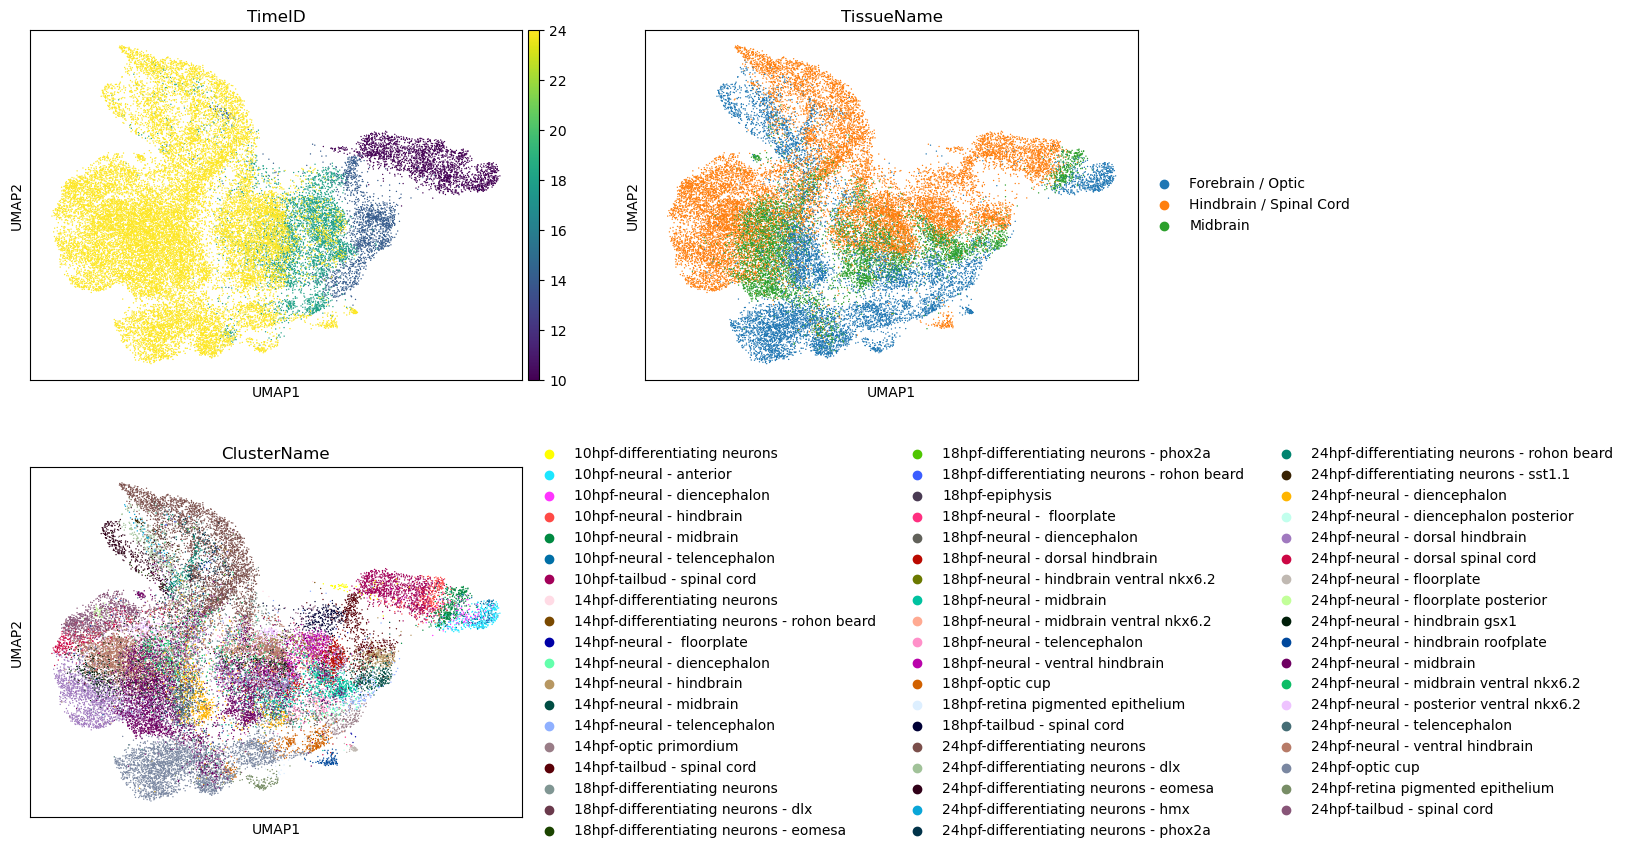

In [25]:
sc.pl.umap(adata_neural, color=['TimeID', 'TissueName', 'ClusterName'], ncols=2)

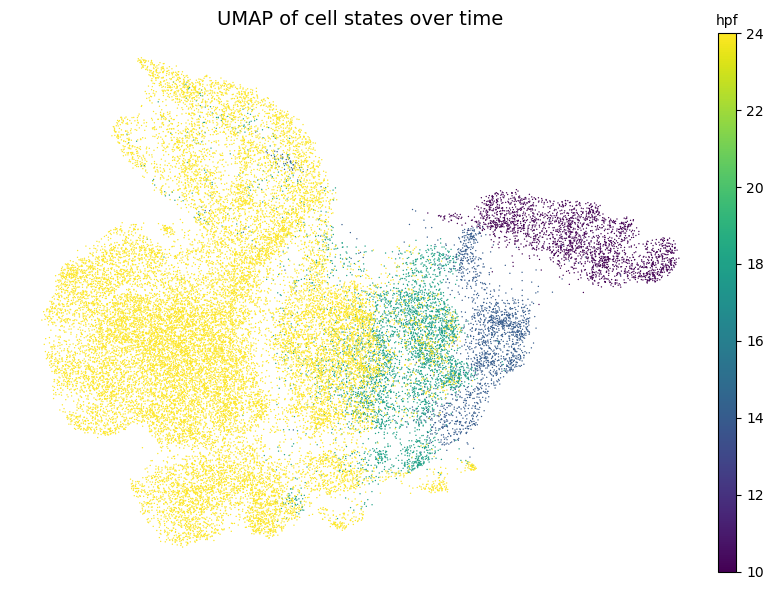

In [182]:
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(adata_neural, color='TimeID', ax=ax, show=False, frameon=False)


cbar = ax.collections[0].colorbar
cbar.ax.set_title('hpf', fontsize=10)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.title('UMAP of cell states over time', fontsize=14)
plt.tight_layout()
plt.savefig('UMAP_of_scRNA-seq_profiles_of_neural_tissues.png', dpi=300, bbox_inches='tight')
plt.show()

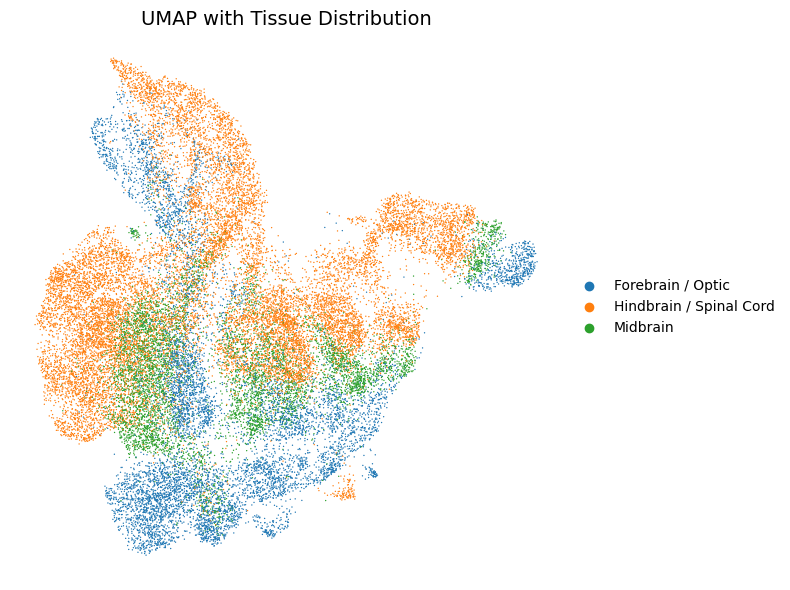

In [183]:
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(adata_neural, color='TissueName', ax=ax, show=False, frameon=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.title('UMAP with Tissue Distribution', fontsize=14)
plt.tight_layout()
plt.savefig('UMAP_of_tissue_profiles_of_neural_tissues.png', dpi=300, bbox_inches='tight')
plt.show()

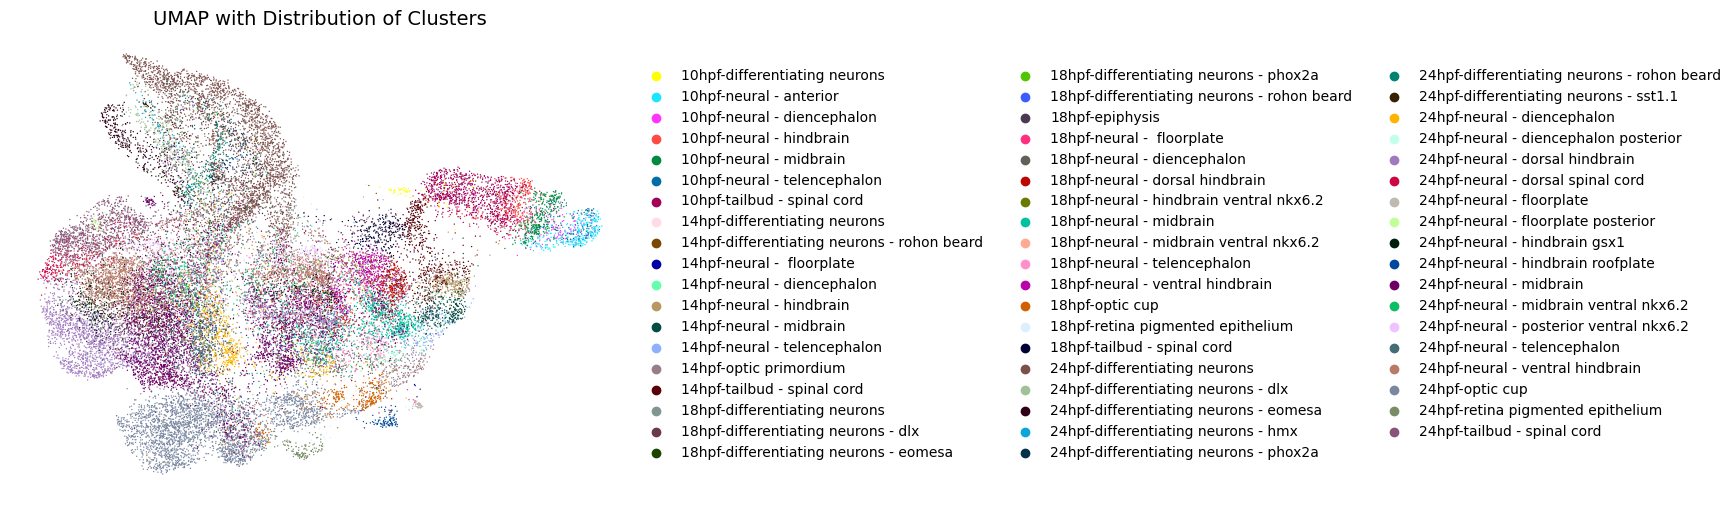

In [184]:
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(adata_neural, color='ClusterName', ax=ax, show=False, frameon=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

plt.title('UMAP with Distribution of Clusters', fontsize=14)
plt.tight_layout()
plt.savefig('UMAP_of_cluster_profiles_of_neural_tissues.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
import wot

#### Computing Transport Matrices

In [28]:
ot_model = wot.ot.OTModel(adata_neural, day_field='TimeID')
ot_model.compute_all_transport_maps(tmap_out='tmaps_neural')

In [30]:
files = os.listdir('tmaps')
print(f"Number of files: {len(files)}")
for f in files:
    print(f)

Number of files: 3
tmaps_neural_10.0_14.0.h5ad
tmaps_neural_18.0_24.0.h5ad
tmaps_neural_14.0_18.0.h5ad


In [31]:
tmap = anndata.read_h5ad('tmaps/tmaps_neural_18.0_24.0.h5ad')
print(tmap)
print("obs (rows = source cells):", tmap.obs.head())
print("var (cols = target cells):", tmap.var.head())

AnnData object with n_obs × n_vars = 3980 × 23070
    obs: 'g0', 'g1'
obs (rows = source cells):          g0        g1
index                
2-0-5   1.0  1.044579
25-0-5  1.0  0.996846
49-0-5  1.0  0.991782
50-0-5  1.0  0.977354
97-0-5  1.0  0.977039
var (cols = target cells): Empty DataFrame
Columns: []
Index: [1-0-6, 2-0-6, 8-0-6, 13-0-6, 14-0-6]


In [33]:
print("adata_neural cell IDs:", adata_neural.obs_names[:5].tolist())

# Get 24 hpf cells from transport map
cells_24_tmap = tmap.var_names.tolist()
print(f"Cells at 24 hpf in tmap: {len(cells_24_tmap)}")

# Check overlap
overlap = set(cells_24_tmap) & set(adata_neural.obs_names)
print(f"Overlap: {len(overlap)}")

adata_neural cell IDs: ['0-0-3', '15-0-3', '31-0-3', '45-0-3', '60-0-3']
Cells at 24 hpf in tmap: 23070
Overlap: 23070


#### Computing Long Range Temporal Couplings

In [185]:
#tmap_model = wot.tmap.TransportMapModel.from_directory('/tmaps/tmaps_neural')

#### Inferring Ancestors and Descendants

In [43]:
adata_24 = adata_neural[adata_neural.obs['TimeID'] == 24.0]
print(adata_24.obs['ClusterName'].value_counts())

ClusterName
24hpf-neural - midbrain                        3920
24hpf-neural - ventral hindbrain               3111
24hpf-optic cup                                3091
24hpf-differentiating neurons                  2921
24hpf-neural - dorsal hindbrain                2520
24hpf-tailbud - spinal cord                    1243
24hpf-neural - telencephalon                   1241
24hpf-neural - hindbrain gsx1                   848
24hpf-neural - diencephalon                     764
24hpf-neural - midbrain ventral nkx6.2          667
24hpf-neural - posterior ventral nkx6.2         469
24hpf-differentiating neurons - eomesa          395
24hpf-differentiating neurons - dlx             394
24hpf-neural - dorsal spinal cord               361
24hpf-differentiating neurons - rohon beard     234
24hpf-differentiating neurons - phox2a          197
24hpf-neural - diencephalon posterior           155
24hpf-retina pigmented epithelium               152
24hpf-neural - hindbrain roofplate              149


In [55]:
# Include all 24 hpf neural clusters (not just differentiating neurons)
adata_24 = adata_neural[adata_neural.obs['TimeID'] == 24.0]
all_24hpf_clusters = adata_24.obs['ClusterName'].unique().tolist()

print("All 24 hpf clusters:")
for c in sorted(all_24hpf_clusters):
    n_cells = (adata_24.obs['ClusterName'] == c).sum()
    print(f"  {c}: {n_cells} cells")

All 24 hpf clusters:
  24hpf-differentiating neurons: 2921 cells
  24hpf-differentiating neurons - dlx: 394 cells
  24hpf-differentiating neurons - eomesa: 395 cells
  24hpf-differentiating neurons - hmx: 83 cells
  24hpf-differentiating neurons - phox2a: 197 cells
  24hpf-differentiating neurons - rohon beard: 234 cells
  24hpf-differentiating neurons - sst1.1: 59 cells
  24hpf-neural - diencephalon : 764 cells
  24hpf-neural - diencephalon posterior: 155 cells
  24hpf-neural - dorsal hindbrain: 2520 cells
  24hpf-neural - dorsal spinal cord: 361 cells
  24hpf-neural - floorplate: 45 cells
  24hpf-neural - floorplate posterior: 51 cells
  24hpf-neural - hindbrain gsx1: 848 cells
  24hpf-neural - hindbrain roofplate: 149 cells
  24hpf-neural - midbrain: 3920 cells
  24hpf-neural - midbrain ventral nkx6.2: 667 cells
  24hpf-neural - posterior ventral nkx6.2: 469 cells
  24hpf-neural - telencephalon: 1241 cells
  24hpf-neural - ventral hindbrain: 3111 cells
  24hpf-optic cup: 3091 cells


In [46]:
target_clusters[2]

'24hpf-neural - dorsal hindbrain'

In [56]:
with open('cell_sets_1.gmt', 'w') as f:
    for cluster in all_24hpf_clusters:
        # Check if cluster exists
        cells = adata_neural[adata_neural.obs['ClusterName'] == cluster].obs_names.tolist()
        if len(cells) > 0:
            set_name = cluster.replace('24hpf-differentiating neurons - ', '').replace('24hpf-differentiating neurons', 'general')
            line = f"{set_name}\t{set_name}\t" + "\t".join(cells) + "\n"
            f.write(line)
            print(f"{set_name}: {len(cells)} cells")
        else:
            print(f"Skipping {cluster}: no cells found")

24hpf-neural - ventral hindbrain: 3111 cells
24hpf-neural - telencephalon: 1241 cells
24hpf-neural - dorsal hindbrain: 2520 cells
24hpf-tailbud - spinal cord: 1243 cells
24hpf-neural - midbrain: 3920 cells
24hpf-neural - hindbrain gsx1: 848 cells
general: 2921 cells
24hpf-neural - diencephalon : 764 cells
24hpf-optic cup: 3091 cells
24hpf-neural - posterior ventral nkx6.2: 469 cells
phox2a: 197 cells
24hpf-neural - dorsal spinal cord: 361 cells
24hpf-neural - midbrain ventral nkx6.2: 667 cells
dlx: 394 cells
24hpf-retina pigmented epithelium: 152 cells
eomesa: 395 cells
hmx: 83 cells
24hpf-neural - hindbrain roofplate: 149 cells
24hpf-neural - diencephalon posterior: 155 cells
sst1.1: 59 cells
rohon beard: 234 cells
24hpf-neural - floorplate: 45 cells
24hpf-neural - floorplate posterior: 51 cells


In [57]:
# Include all 24 hpf neural clusters (not just differentiating neurons)
adata_24 = adata_neural[adata_neural.obs['TimeID'] == 24.0]
all_24hpf_clusters = adata_24.obs['ClusterName'].unique().tolist()

print("All 24 hpf clusters:")
for c in sorted(all_24hpf_clusters):
    n_cells = (adata_24.obs['ClusterName'] == c).sum()
    print(f"  {c}: {n_cells} cells")

All 24 hpf clusters:
  24hpf-differentiating neurons: 2921 cells
  24hpf-differentiating neurons - dlx: 394 cells
  24hpf-differentiating neurons - eomesa: 395 cells
  24hpf-differentiating neurons - hmx: 83 cells
  24hpf-differentiating neurons - phox2a: 197 cells
  24hpf-differentiating neurons - rohon beard: 234 cells
  24hpf-differentiating neurons - sst1.1: 59 cells
  24hpf-neural - diencephalon : 764 cells
  24hpf-neural - diencephalon posterior: 155 cells
  24hpf-neural - dorsal hindbrain: 2520 cells
  24hpf-neural - dorsal spinal cord: 361 cells
  24hpf-neural - floorplate: 45 cells
  24hpf-neural - floorplate posterior: 51 cells
  24hpf-neural - hindbrain gsx1: 848 cells
  24hpf-neural - hindbrain roofplate: 149 cells
  24hpf-neural - midbrain: 3920 cells
  24hpf-neural - midbrain ventral nkx6.2: 667 cells
  24hpf-neural - posterior ventral nkx6.2: 469 cells
  24hpf-neural - telencephalon: 1241 cells
  24hpf-neural - ventral hindbrain: 3111 cells
  24hpf-optic cup: 3091 cells


In [58]:
with open('cell_sets.gmt', 'w') as f:
    for cluster in all_24hpf_clusters:
        set_name = cluster.replace('24hpf-differentiating neurons - ', '')
        cells = adata_neural[adata_neural.obs['ClusterName'] == cluster].obs_names.tolist()
        line = f"{set_name}\t{set_name}\t" + "\t".join(cells) + "\n"
        f.write(line)
        print(f"{set_name}: {len(cells)} cells")

24hpf-neural - ventral hindbrain: 3111 cells
24hpf-neural - telencephalon: 1241 cells
24hpf-neural - dorsal hindbrain: 2520 cells
24hpf-tailbud - spinal cord: 1243 cells
24hpf-neural - midbrain: 3920 cells
24hpf-neural - hindbrain gsx1: 848 cells
24hpf-differentiating neurons: 2921 cells
24hpf-neural - diencephalon : 764 cells
24hpf-optic cup: 3091 cells
24hpf-neural - posterior ventral nkx6.2: 469 cells
phox2a: 197 cells
24hpf-neural - dorsal spinal cord: 361 cells
24hpf-neural - midbrain ventral nkx6.2: 667 cells
dlx: 394 cells
24hpf-retina pigmented epithelium: 152 cells
eomesa: 395 cells
hmx: 83 cells
24hpf-neural - hindbrain roofplate: 149 cells
24hpf-neural - diencephalon posterior: 155 cells
sst1.1: 59 cells
rohon beard: 234 cells
24hpf-neural - floorplate: 45 cells
24hpf-neural - floorplate posterior: 51 cells


In [66]:

cell_sets = wot.io.read_sets('cell_sets.gmt', as_dict=True)
print("Cell sets:", cell_sets.keys())

Cell sets: dict_keys(['24hpf-neural - ventral hindbrain', '24hpf-neural - telencephalon', '24hpf-neural - dorsal hindbrain', '24hpf-tailbud - spinal cord', '24hpf-neural - midbrain', '24hpf-neural - hindbrain gsx1', '24hpf-differentiating neurons', '24hpf-neural - diencephalon', '24hpf-optic cup', '24hpf-neural - posterior ventral nkx6.2', 'phox2a', '24hpf-neural - dorsal spinal cord', '24hpf-neural - midbrain ventral nkx6.2', 'dlx', '24hpf-retina pigmented epithelium', 'eomesa', 'hmx', '24hpf-neural - hindbrain roofplate', '24hpf-neural - diencephalon posterior', 'sst1.1', 'rohon beard', '24hpf-neural - floorplate', '24hpf-neural - floorplate posterior'])


In [67]:
populations = tmap_model.population_from_cell_sets(cell_sets, at_time=24.0)
print("Populations:", populations)

# Compute trajectories (ancestors and descendants)
trajectory_ds = tmap_model.trajectories(populations)
print(trajectory_ds)

Populations: [<wot.population.Population object at 0x7f9056f75c70>, <wot.population.Population object at 0x7f9056f760f0>, <wot.population.Population object at 0x7f9056f761b0>, <wot.population.Population object at 0x7f9056f76270>, <wot.population.Population object at 0x7f9056f76330>, <wot.population.Population object at 0x7f9056f763f0>, <wot.population.Population object at 0x7f9056f764b0>, <wot.population.Population object at 0x7f9056f76570>, <wot.population.Population object at 0x7f9056f76630>, <wot.population.Population object at 0x7f9056f766f0>, <wot.population.Population object at 0x7f9056f767b0>, <wot.population.Population object at 0x7f9056f76870>, <wot.population.Population object at 0x7f9056f76930>, <wot.population.Population object at 0x7f9056f769f0>, <wot.population.Population object at 0x7f9056f76ab0>, <wot.population.Population object at 0x7f9056f76b70>, <wot.population.Population object at 0x7f9056f76c30>, <wot.population.Population object at 0x7f9056f76cf0>, <wot.populatio

In [69]:
for cell_set_name in cell_sets.keys():
    # Initialize column
    adata_neural.obs[f'traj_{cell_set_name}'] = 0.0
    
    # Get trajectory probabilities for this cell set
    for i, timepoint in enumerate(trajectory_ds.obs['day'].unique()):
        traj_at_t = trajectory_ds[trajectory_ds.obs['day'] == timepoint]
        if cell_set_name in traj_at_t.var_names:
            probs = traj_at_t[:, cell_set_name].X.flatten()
            cell_ids = traj_at_t.obs_names
            
            for cell_id, prob in zip(cell_ids, probs):
                if cell_id in adata_neural.obs_names:
                    adata_neural.obs.loc[cell_id, f'traj_{cell_set_name}'] = prob

In [81]:
# Checking available trajectory columns
traj_cols = [col for col in adata_neural.obs.columns if col.startswith('traj_')]
print("Available trajectory columns:")
for col in traj_cols:
    print(f"  '{col}'")

# Checking cell_sets keys
print("\nCell sets keys:")
for key in cell_sets.keys():
    print(f"  '{key}'")

Available trajectory columns:
  'traj_24hpf-neural - ventral hindbrain'
  'traj_24hpf-neural - telencephalon'
  'traj_24hpf-neural - dorsal hindbrain'
  'traj_24hpf-tailbud - spinal cord'
  'traj_24hpf-neural - midbrain'
  'traj_24hpf-neural - hindbrain gsx1'
  'traj_general'
  'traj_24hpf-neural - diencephalon'
  'traj_24hpf-optic cup'
  'traj_24hpf-neural - posterior ventral nkx6.2'
  'traj_phox2a'
  'traj_24hpf-neural - dorsal spinal cord'
  'traj_24hpf-neural - midbrain ventral nkx6.2'
  'traj_dlx'
  'traj_24hpf-retina pigmented epithelium'
  'traj_eomesa'
  'traj_hmx'
  'traj_24hpf-neural - hindbrain roofplate'
  'traj_24hpf-neural - diencephalon posterior'
  'traj_sst1.1'
  'traj_rohon beard'
  'traj_24hpf-neural - floorplate'
  'traj_24hpf-neural - floorplate posterior'
  'traj_24hpf-differentiating neurons'

Cell sets keys:
  '24hpf-neural - ventral hindbrain'
  '24hpf-neural - telencephalon'
  '24hpf-neural - dorsal hindbrain'
  '24hpf-tailbud - spinal cord'
  '24hpf-neural - 

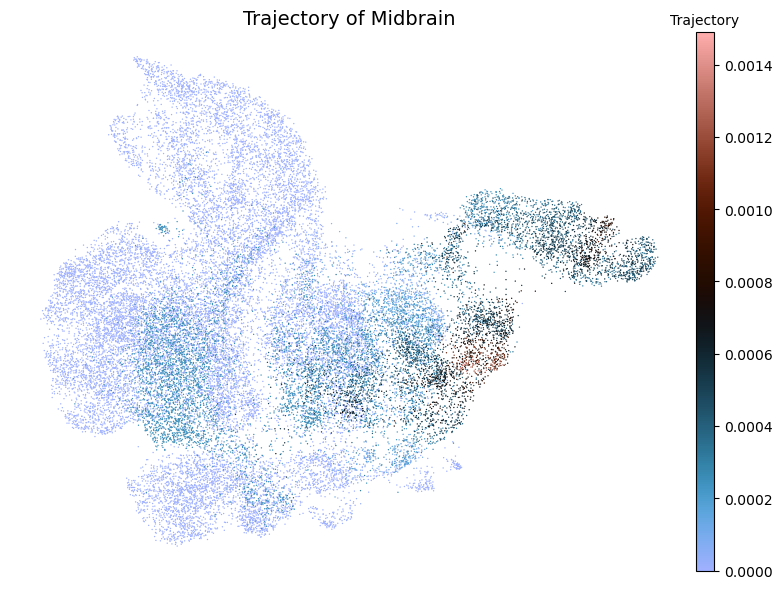

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(adata_neural, color=['traj_24hpf-neural - midbrain'], ax=ax, show=False, frameon=False, cmap = 'berlin')

# Get colorbar and add title on top
cbar = ax.collections[0].colorbar
cbar.ax.set_title('Trajectory', fontsize=10)

plt.title('Trajectory of Midbrain', fontsize=14)
plt.tight_layout()
plt.savefig('Midbrain_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

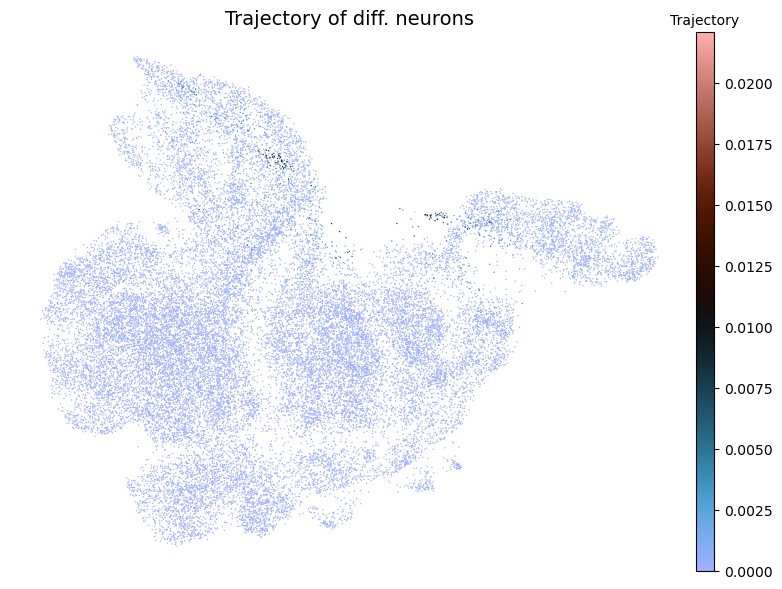

In [83]:
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(adata_neural, color=['traj_24hpf-differentiating neurons'], ax=ax, show=False, frameon=False, cmap = 'berlin')

# Get colorbar and add title on top
cbar = ax.collections[0].colorbar
cbar.ax.set_title('Trajectory', fontsize=10)

plt.title('Trajectory of diff. neurons', fontsize=14)
plt.tight_layout()
plt.savefig('Diff_neurons_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

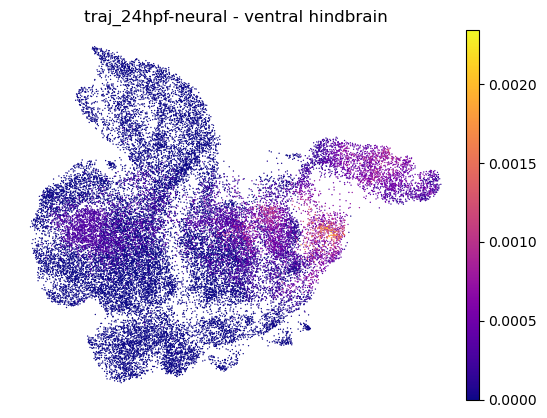

In [73]:

sc.pl.umap(
    adata_neural,
    color=['traj_24hpf-neural - ventral hindbrain'],
    cmap='plasma',
    ncols=2,
    frameon=False
)

#### Analyzing Trajectory Trends

In [84]:
#Computing trends across genes

trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(trajectory_ds, adata_neural)

In [86]:
# Saving each trajectory in separate file
output_dir = 'trajectory_results'
os.makedirs(output_dir, exist_ok=True)

# Save each trajectory in the directory
for i in range(len(trajectory_trends)):
    filename = os.path.join(output_dir, trajectory_ds.var.index[i] + '_trends.txt')
    wot.io.write_dataset(trajectory_trends[i], filename)
    print(f"Saved: {filename}")

Saved: trajectory_results/24hpf-neural - ventral hindbrain_trends.txt
Saved: trajectory_results/24hpf-neural - telencephalon_trends.txt
Saved: trajectory_results/24hpf-neural - dorsal hindbrain_trends.txt
Saved: trajectory_results/24hpf-tailbud - spinal cord_trends.txt
Saved: trajectory_results/24hpf-neural - midbrain_trends.txt
Saved: trajectory_results/24hpf-neural - hindbrain gsx1_trends.txt
Saved: trajectory_results/24hpf-differentiating neurons_trends.txt
Saved: trajectory_results/24hpf-neural - diencephalon_trends.txt
Saved: trajectory_results/24hpf-optic cup_trends.txt
Saved: trajectory_results/24hpf-neural - posterior ventral nkx6.2_trends.txt
Saved: trajectory_results/phox2a_trends.txt
Saved: trajectory_results/24hpf-neural - dorsal spinal cord_trends.txt
Saved: trajectory_results/24hpf-neural - midbrain ventral nkx6.2_trends.txt
Saved: trajectory_results/dlx_trends.txt
Saved: trajectory_results/24hpf-retina pigmented epithelium_trends.txt
Saved: trajectory_results/eomesa_tren

In [188]:
trajectory_trend_datasets = []
trajectory_names = []

# Definining directory where trends are saved
#trends_dir = '/trajectory_results'  

# List available trend files
trend_files = [f for f in os.listdir(trends_dir) if f.endswith('_trends.txt')]
print("Available trend files:")
for f in trend_files:
    print(f"  {f}")

# Load all trajectory trends
trajectory_trend_datasets = []
trajectory_names = []

for f in trend_files:
    filepath = os.path.join(trends_dir, f)
    trend_ds = wot.io.read_dataset(filepath)
    trajectory_trend_datasets.append(trend_ds)
    name = f.replace('_trends.txt', '')
    trajectory_names.append(name)
    print(f"Loaded: {name}")

Available trend files:
  24hpf-neural - diencephalon_trends.txt
  24hpf-neural - diencephalon posterior_trends.txt
  24hpf-neural - posterior ventral nkx6.2_trends.txt
  24hpf-neural - floorplate_trends.txt
  24hpf-retina pigmented epithelium_trends.txt
  24hpf-neural - floorplate posterior_trends.txt
  dlx_trends.txt
  24hpf-neural - midbrain ventral nkx6.2_trends.txt
  24hpf-optic cup_trends.txt
  24hpf-neural - ventral hindbrain_trends.txt
  24hpf-neural - telencephalon_trends.txt
  24hpf-differentiating neurons_trends.txt
  sst1.1_trends.txt
  24hpf-tailbud - spinal cord_trends.txt
  24hpf-neural - dorsal spinal cord_trends.txt
  hmx_trends.txt
  24hpf-neural - hindbrain roofplate_trends.txt
  phox2a_trends.txt
  24hpf-neural - midbrain_trends.txt
  24hpf-neural - hindbrain gsx1_trends.txt
  rohon beard_trends.txt
  eomesa_trends.txt
  24hpf-neural - dorsal hindbrain_trends.txt
Loaded: 24hpf-neural - diencephalon
Loaded: 24hpf-neural - diencephalon posterior
Loaded: 24hpf-neural - 

In [189]:
# Check available genes in trajectory trend datasets
#print("Available genes in trajectory trends:")
#print(trajectory_trend_datasets[0].var.index.tolist())

# Or show first 50 genes
print("\nFirst 50 genes:")
print(trajectory_trend_datasets[0].var.index[:50].tolist())

# Searching for specific neural markers
neural_markers = ['sox2', 'neurod1', 'elavl3', 'pax6', 'neurog1', 'ascl1', 'dlx', 'phox2a', 'isl1']
available_markers = [g for g in trajectory_trend_datasets[0].var.index if any(m in g.lower() for m in neural_markers)]
print("\nAvailable neural markers:")
print(available_markers)


First 50 genes:
['sema5bb', 'si:dkey-33c12.12', 'slc22a7b.4', 'LOC100000086', 'lbhl', 'si:ch211-176l24.4', 'LOC100000110', 'tmem245', 'mhc1lca', 'tex264b', 'si:zfos-411a11.2', 'si:dkey-16l2.20', 'si:dkey-29g22.2', 'LOC100000228', 'si:ch1073-83n3.2', 'si:ch73-335l21.2', 'LOC100000275', 'atg2b', 'si:ch73-167i17.7', 'si:ch73-335l21.4', 'si:dkey-152b24.7', 'LOC100000365', 'LOC100000384', 'atp6ap1la', 'LOC100000417', 'si:ch73-233f7.6', 'LOC100000458', 'LOC100000504', 'LOC100000545', 'si:ch73-368j24.13', 'abcf2b', 'LOC100000613', 'LOC100000633', 'si:dkeyp-91b5.1', 'LOC100000671', 'pimr190', 'slc22a5', 'LOC100000694', 'prrg3', 'tedc2', 'dydc2', 'LOC100000772', 'si:ch73-368j24.14', 'zmp:0000001274', 'si:dkey-172o19.2', 'LOC100000832', 'si:dkey-83f18.2', 'si:ch73-368j24.10', 'smdt1b', 'LOC100000863']

Available neural markers:
['sox2ot', 'ascl1a', 'ascl1b', 'dlx1a', 'dlx2a', 'dlx2b', 'dlx3b', 'dlx4a', 'dlx4b', 'dlx5a', 'dlx6a', 'elavl3', 'isl1', 'isl1l', 'neurod1', 'neurog1', 'pax6a', 'pax6b',

In [190]:
# Search function
def search_genes(keyword, trend_ds):
    matches = [g for g in trend_ds.var.index if keyword.lower() in g.lower()]
    return matches

In [112]:
print("Genes containing 'notch1b':", search_genes('notch1b', trajectory_trend_datasets[0]))

Genes containing 'notch1b': ['notch1b']


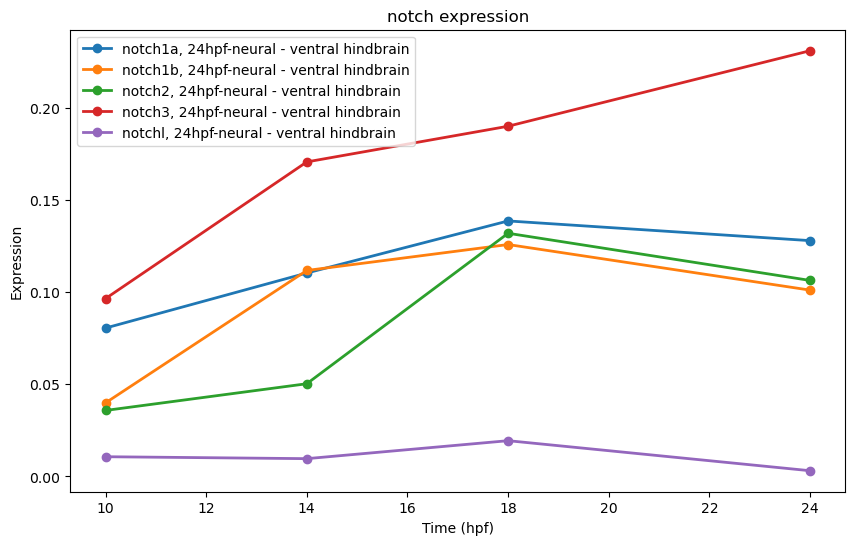

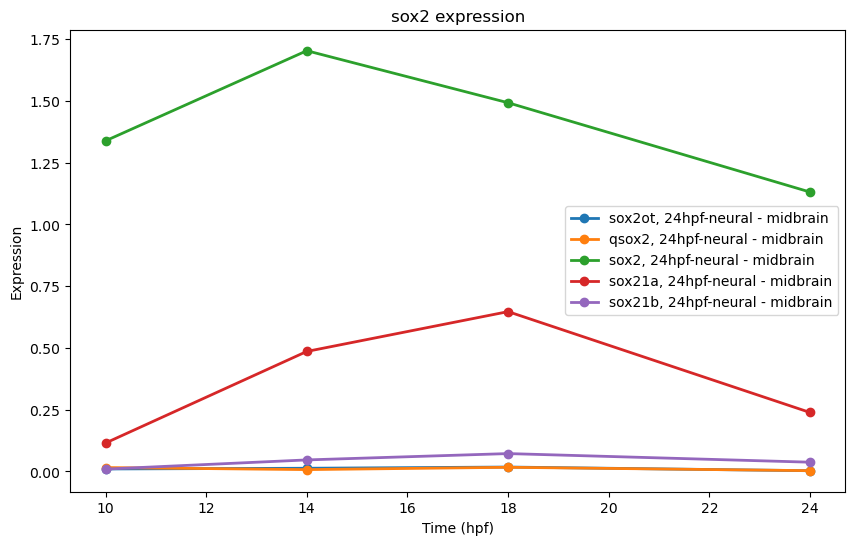

In [126]:
def plot_gene_trajectory(gene_name, trajectory_name):
    """Plot gene expression along a trajectory"""
    trajectory_index = trajectory_names.index(trajectory_name)
    trend_ds = trajectory_trend_datasets[trajectory_index]
    
    # Find gene (case-insensitive)
    gene_matches = [g for g in trend_ds.var.index if gene_name.lower() in g.lower()]
    
    if not gene_matches:
        print(f"Gene '{gene_name}' not found")
        return
    
    plt.figure(figsize=(10, 6))
    timepoints = trend_ds.obs.index.values.astype(float)
    
    for gene in gene_matches:
        values = trend_ds[:, gene].X.flatten()
        plt.plot(timepoints, values, 'o-', label=f"{gene}, {trajectory_name}", linewidth=2)
    
    plt.xlabel("Time (hpf)")
    plt.ylabel("Expression")
    plt.legend()
    plt.title(f"{gene_name} expression")
    plt.show()

# Usage
plot_gene_trajectory('notch', '24hpf-neural - ventral hindbrain')
plot_gene_trajectory('sox2', '24hpf-neural - midbrain')

Top 5 trajectories for sox21a:
  24hpf-neural - ventral hindbrain: 0.883
  24hpf-neural - hindbrain gsx1: 0.693
  24hpf-neural - midbrain: 0.647
  24hpf-tailbud - spinal cord: 0.627
  24hpf-neural - midbrain ventral nkx6.2: 0.585


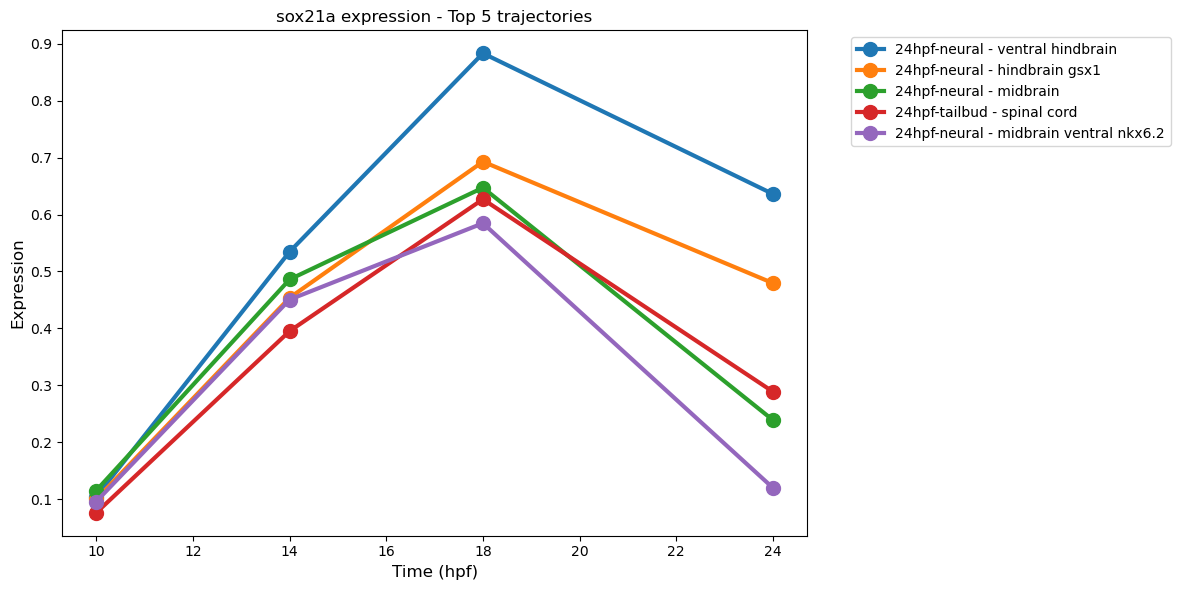

In [137]:
def plot_gene_top_trajectories(gene_name, top_n=5, save_path=None):
    """Plot gene expression for top N trajectories by peak expression"""
    
    # Calculate peak expression for each trajectory
    peak_values = []
    for traj_name in trajectory_names:
        trajectory_index = trajectory_names.index(traj_name)
        trend_ds = trajectory_trend_datasets[trajectory_index]
        gene_matches = [g for g in trend_ds.var.index if gene_name.lower() in g.lower()]
        
        if gene_matches:
            values = trend_ds[:, gene_matches[0]].X.flatten()
            peak_values.append((traj_name, max(values)))
        else:
            peak_values.append((traj_name, 0))
    
    # Sort and get top N
    top_trajectories = sorted(peak_values, key=lambda x: x[1], reverse=True)[:top_n]
    top_names = [t[0] for t in top_trajectories]
    
    print(f"Top {top_n} trajectories for {gene_name}:")
    for name, val in top_trajectories:
        print(f"  {name}: {val:.3f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10(range(top_n))
    
    for i, traj_name in enumerate(top_names):
        trajectory_index = trajectory_names.index(traj_name)
        trend_ds = trajectory_trend_datasets[trajectory_index]
        gene_matches = [g for g in trend_ds.var.index if gene_name.lower() in g.lower()]
        
        gene = gene_matches[0]
        timepoints = trend_ds.obs.index.values.astype(float)
        values = trend_ds[:, gene].X.flatten()
        
        plt.plot(timepoints, values, 'o-', label=traj_name, 
                linewidth=3, markersize=10, color=colors[i])
    
    plt.xlabel("Time (hpf)", fontsize=12)
    plt.ylabel("Expression", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.title(f"{gene_name} expression - Top {top_n} trajectories")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_gene_top_trajectories('sox21a', top_n=5)

Top 5 trajectories for sox21b:
  24hpf-neural - ventral hindbrain: 0.094
  24hpf-neural - hindbrain gsx1: 0.080
  24hpf-neural - midbrain ventral nkx6.2: 0.076
  24hpf-neural - midbrain: 0.073
  24hpf-neural - posterior ventral nkx6.2: 0.071


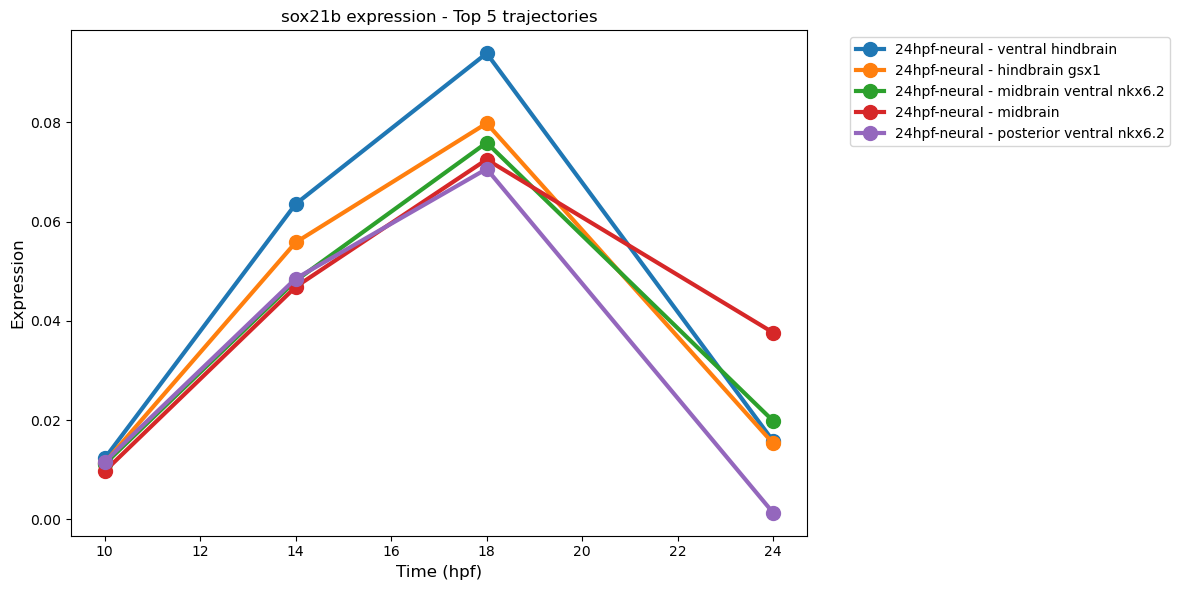

In [141]:
plot_gene_top_trajectories('sox21b', top_n=5)

Top 5 trajectories for pax6:
  24hpf-neural - ventral hindbrain: 1.261
  24hpf-neural - hindbrain gsx1: 1.251
  24hpf-optic cup: 1.048
  24hpf-neural - dorsal spinal cord: 1.011
  24hpf-tailbud - spinal cord: 0.968


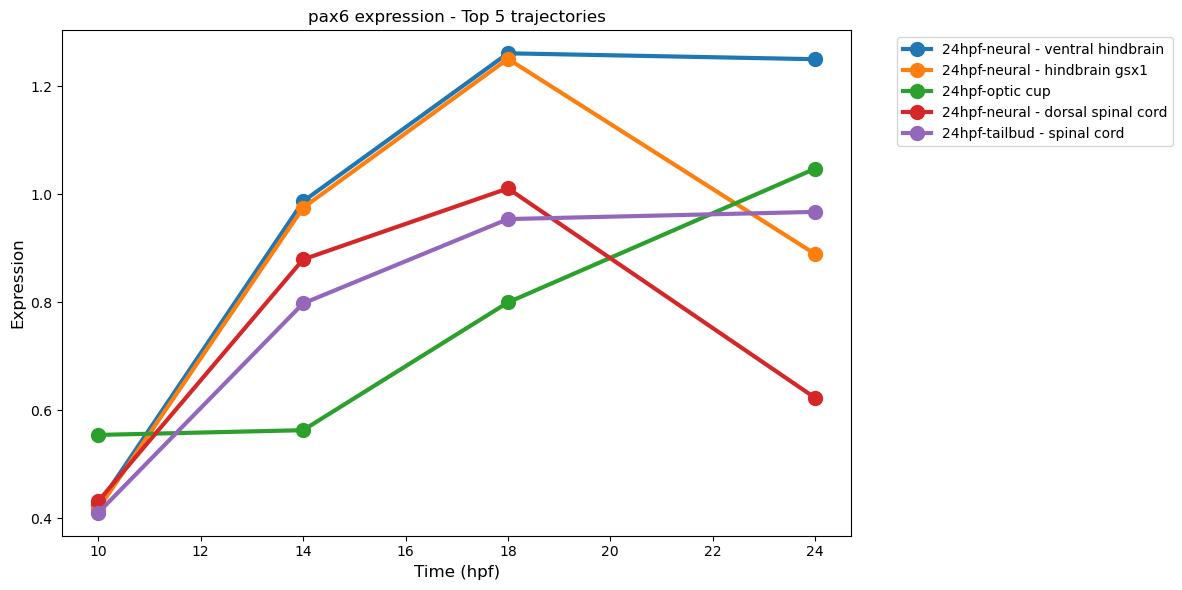

In [138]:
plot_gene_top_trajectories('pax6')

Top 5 trajectories for notch1a:
  eomesa: 0.244
  24hpf-differentiating neurons: 0.223
  hmx: 0.223
  phox2a: 0.215
  dlx: 0.201


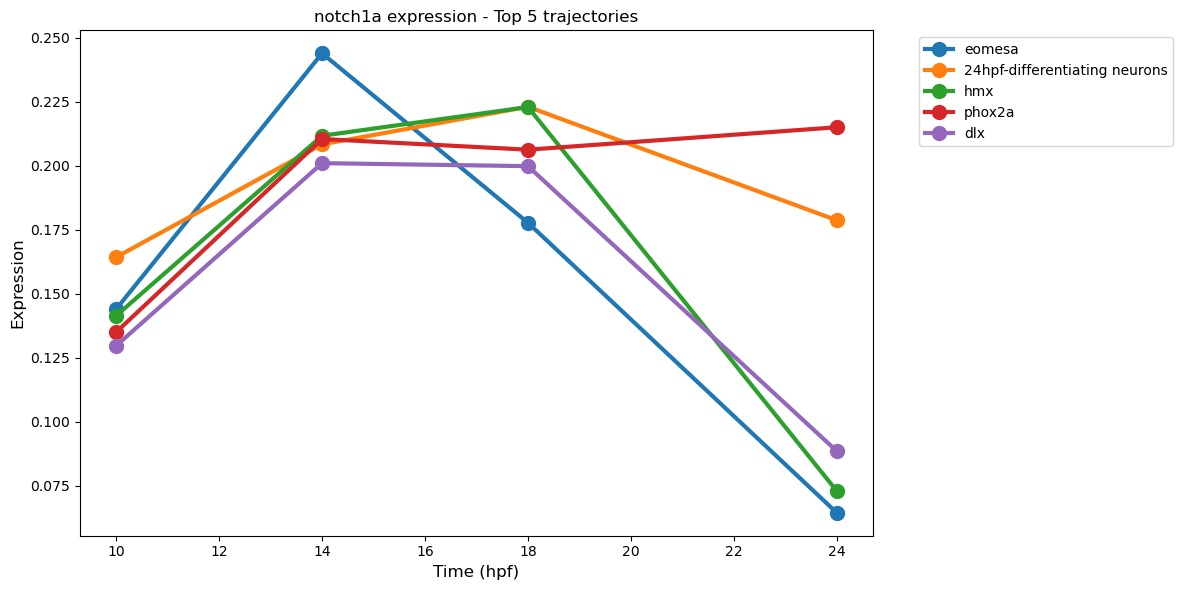

In [139]:
plot_gene_top_trajectories('notch1a')

Top 5 trajectories for elavl3:
  phox2a: 4.847
  24hpf-differentiating neurons: 4.440
  eomesa: 4.359
  dlx: 4.329
  sst1.1: 4.208


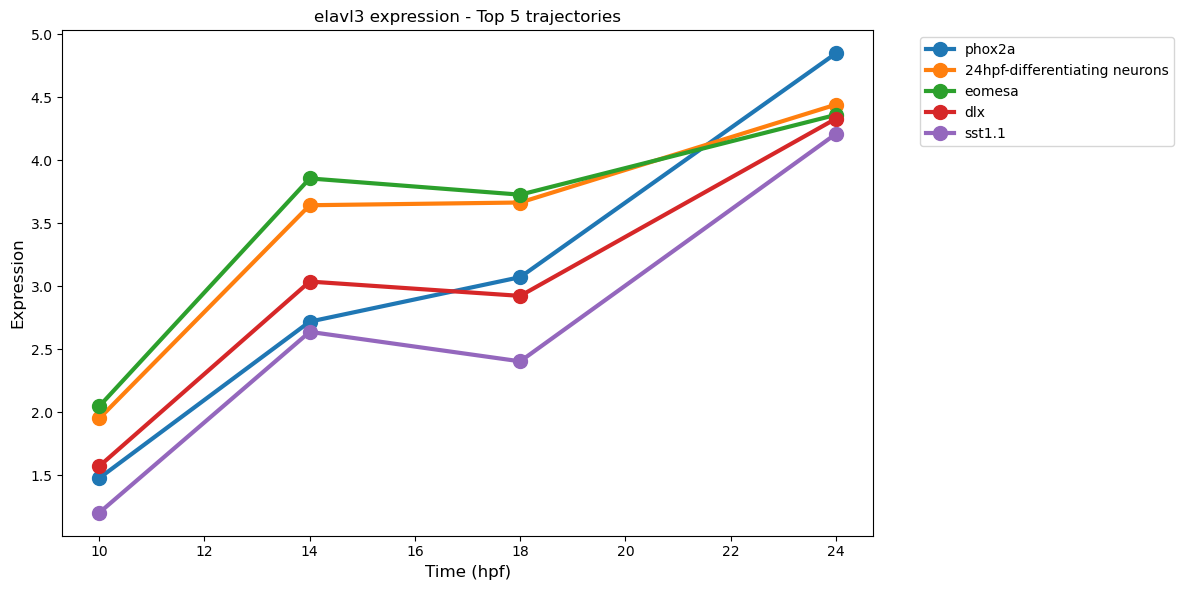

In [142]:
plot_gene_top_trajectories('elavl3')

Top 5 trajectories for sox1b:
  sst1.1: 1.982
  hmx: 1.502
  dlx: 0.917
  24hpf-neural - telencephalon: 0.766
  24hpf-neural - diencephalon: 0.677


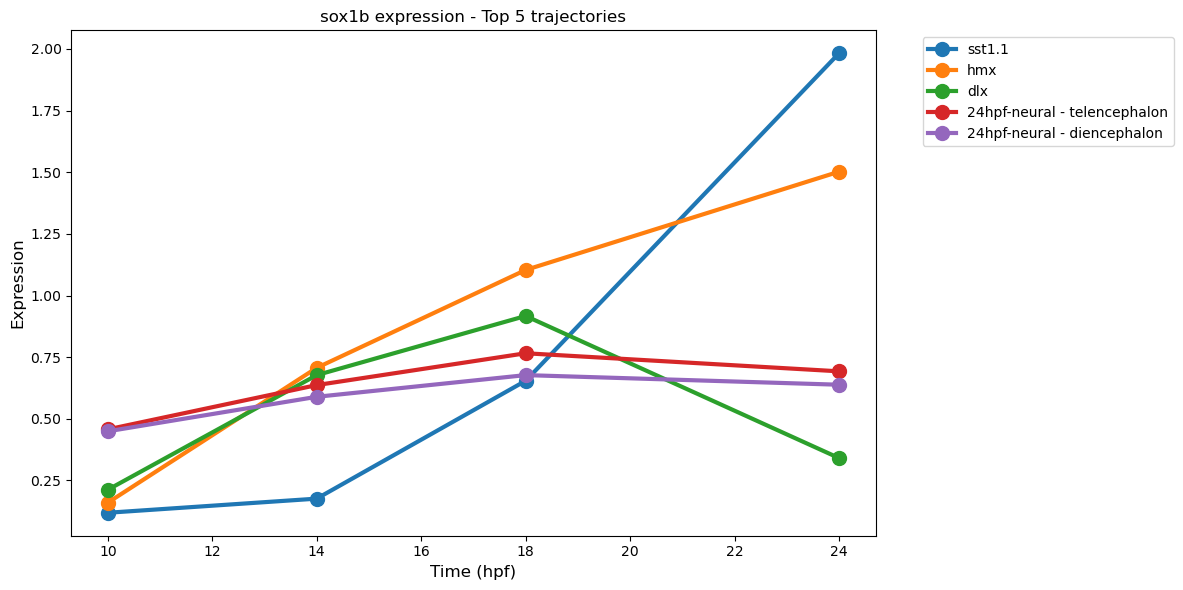

In [143]:
plot_gene_top_trajectories('sox1b')

Top 5 trajectories for sox1a:
  hmx: 1.755
  sst1.1: 1.356
  dlx: 0.244
  24hpf-optic cup: 0.222
  24hpf-neural - telencephalon: 0.203


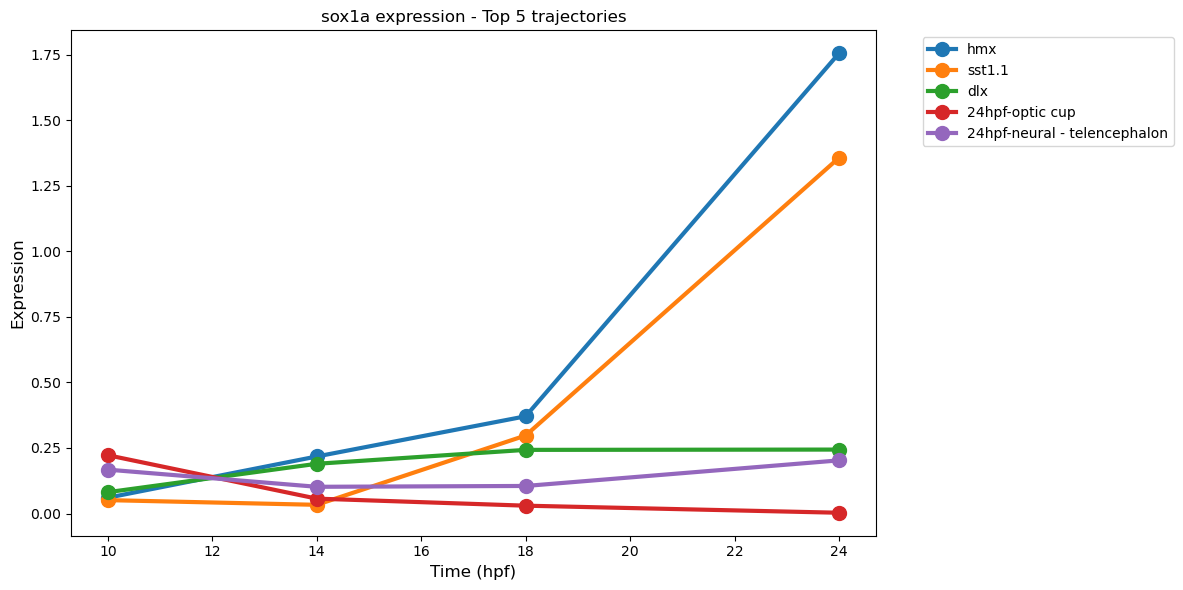

In [144]:
plot_gene_top_trajectories('sox1a')

Top 5 trajectories for neurog1:
  24hpf-differentiating neurons: 1.120
  eomesa: 1.066
  hmx: 0.980
  phox2a: 0.872
  dlx: 0.832


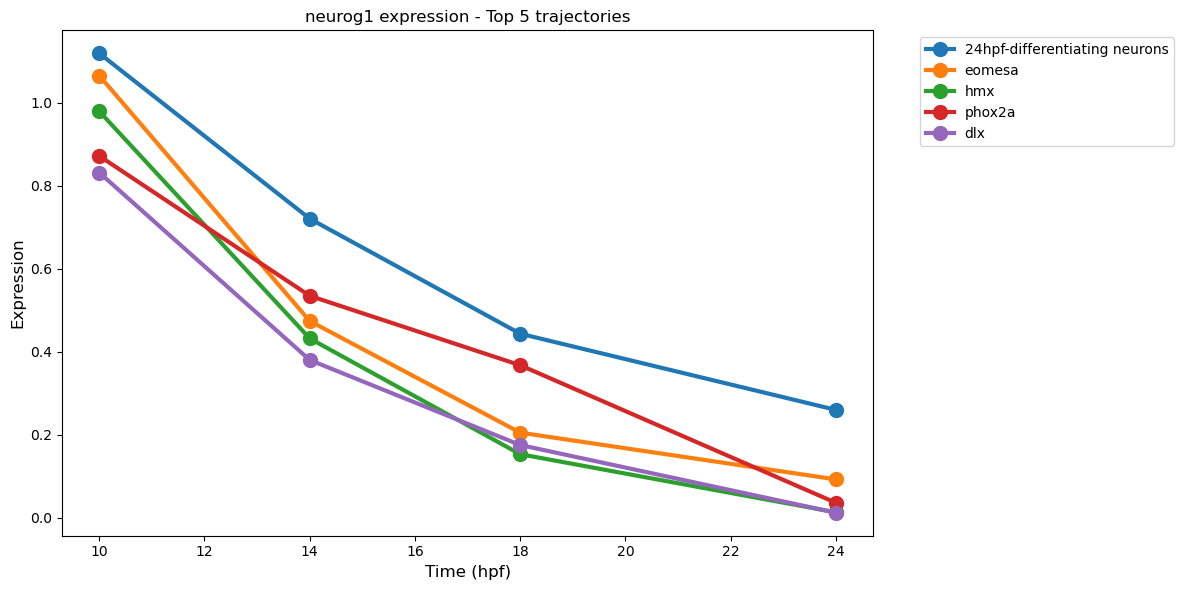

In [145]:
plot_gene_top_trajectories('neurog1')

Top 5 trajectories for ascl1a:
  24hpf-optic cup: 0.662
  24hpf-neural - telencephalon: 0.318
  dlx: 0.282
  hmx: 0.275
  24hpf-neural - midbrain ventral nkx6.2: 0.250


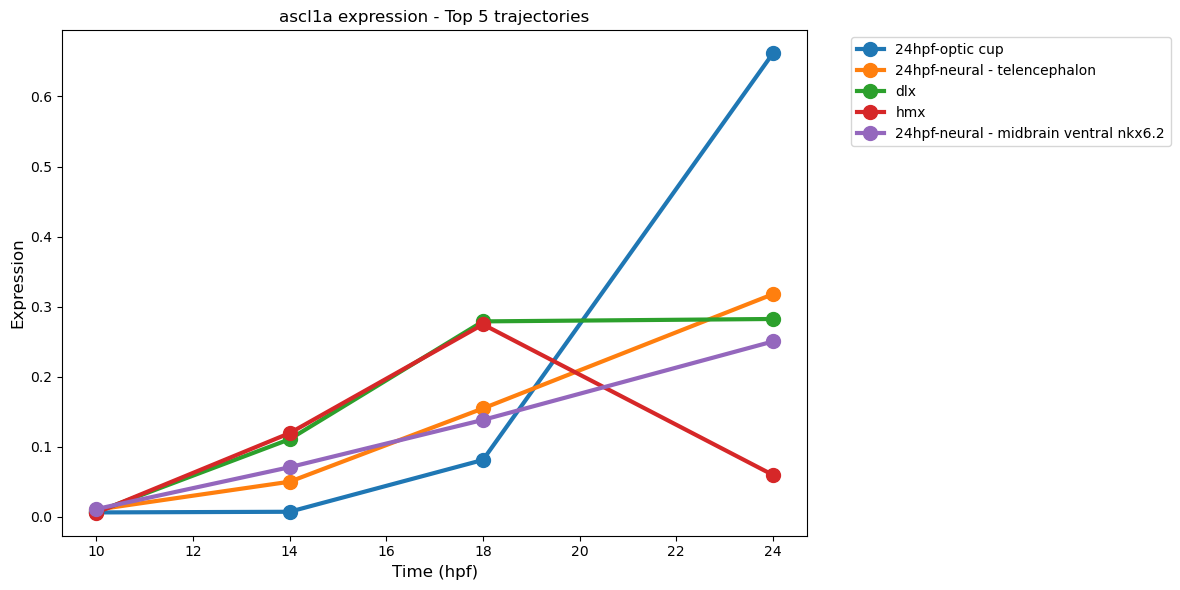

In [146]:
plot_gene_top_trajectories('ascl1a')

In [148]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Expression matrix: 49 genes x 92 conditions


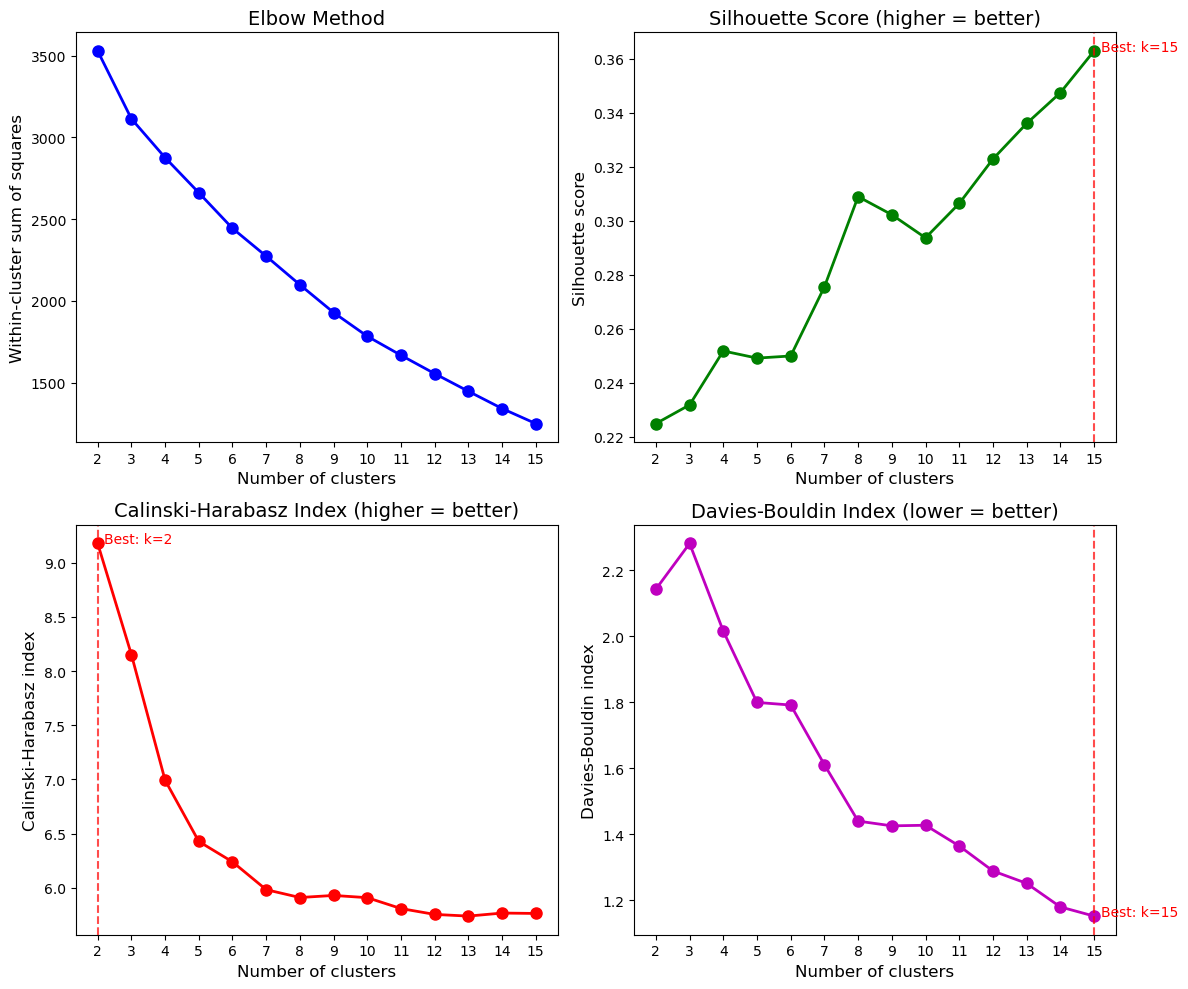


CLUSTER NUMBER RECOMMENDATIONS
Silhouette score suggests:      k = 15
Calinski-Harabasz suggests:     k = 2
Davies-Bouldin suggests:        k = 15

Consensus recommendation:       k = 15

Detailed scores:
 k  silhouette  calinski_harabasz  davies_bouldin        wcss
 2    0.224789           9.175662        2.142952 3528.622422
 3    0.231722           8.151652        2.281389 3113.882942
 4    0.251717           6.993301        2.015742 2876.446977
 5    0.249069           6.428853        1.799839 2661.824505
 6    0.249857           6.240676        1.791881 2443.995012
 7    0.275482           5.984292        1.611031 2273.711110
 8    0.308952           5.911946        1.440276 2098.932611
 9    0.302240           5.931074        1.425890 1929.135451
10    0.293661           5.910527        1.427687 1784.078549
11    0.306406           5.810119        1.364978 1667.670885
12    0.322875           5.756187        1.289250 1555.529189
13    0.336060           5.740709        1.251688 

In [150]:
def evaluate_cluster_numbers(gene_list, max_clusters=15):
    """
    Evaluate different numbers of clusters using multiple metrics.
    """
    
    # First, build the expression matrix (genes x trajectories x timepoints)
    expression_data = {}
    
    for traj_name in trajectory_names:
        trajectory_index = trajectory_names.index(traj_name)
        trend_ds = trajectory_trend_datasets[trajectory_index]
        timepoints = trend_ds.obs.index.values.astype(float)
        
        for gene in gene_list:
            gene_matches = [g for g in trend_ds.var.index if gene.lower() in g.lower()]
            
            if gene_matches:
                gene_name = gene_matches[0]
                values = trend_ds[:, gene_name].X.flatten()
                
                if gene_name not in expression_data:
                    expression_data[gene_name] = {}
                
                # Include timepoint in column name for temporal resolution
                for t, v in zip(timepoints, values):
                    col_name = f"{traj_name.replace('24hpf-neural - ', '').replace('24hpf-', '')}_{int(t)}hpf"
                    expression_data[gene_name][col_name] = v
    
    # Create DataFrame
    df = pd.DataFrame(expression_data).T
    df = df.dropna(how='all')
    df = df.loc[(df != 0).any(axis=1)]
    
    # Z-score normalize
    df_zscore = df.apply(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x, axis=1)
    df_zscore = df_zscore.fillna(0)
    
    print(f"Expression matrix: {df_zscore.shape[0]} genes x {df_zscore.shape[1]} conditions")
    
    # Compute linkage
    dist_matrix = pdist(df_zscore.values, metric='correlation')
    Z = linkage(dist_matrix, method='ward')
    
    # Evaluate different cluster numbers
    k_range = range(2, max_clusters + 1)
    
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    within_cluster_ss = []
    
    for k in k_range:
        labels = fcluster(Z, k, criterion='maxclust')
        
        # Silhouette score (higher is better, range -1 to 1)
        sil = silhouette_score(df_zscore.values, labels, metric='correlation')
        silhouette_scores.append(sil)
        
        # Calinski-Harabasz index (higher is better)
        ch = calinski_harabasz_score(df_zscore.values, labels)
        calinski_scores.append(ch)
        
        # Davies-Bouldin index (lower is better)
        db = davies_bouldin_score(df_zscore.values, labels)
        davies_bouldin_scores.append(db)
        
        # Within-cluster sum of squares (for elbow method)
        wcss = 0
        for cluster_id in range(1, k + 1):
            cluster_points = df_zscore.values[labels == cluster_id]
            if len(cluster_points) > 0:
                centroid = cluster_points.mean(axis=0)
                wcss += np.sum((cluster_points - centroid) ** 2)
        within_cluster_ss.append(wcss)
    
    # Plot all metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Elbow plot
    ax1 = axes[0, 0]
    ax1.plot(k_range, within_cluster_ss, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of clusters', fontsize=12)
    ax1.set_ylabel('Within-cluster sum of squares', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14)
    ax1.set_xticks(list(k_range))
    
    # Silhouette score
    ax2 = axes[0, 1]
    ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of clusters', fontsize=12)
    ax2.set_ylabel('Silhouette score', fontsize=12)
    ax2.set_title('Silhouette Score (higher = better)', fontsize=14)
    ax2.set_xticks(list(k_range))
    best_sil = k_range[np.argmax(silhouette_scores)]
    ax2.axvline(x=best_sil, color='r', linestyle='--', alpha=0.7)
    ax2.text(best_sil + 0.2, max(silhouette_scores), f'Best: k={best_sil}', color='r')
    
    # Calinski-Harabasz
    ax3 = axes[1, 0]
    ax3.plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
    ax3.set_xlabel('Number of clusters', fontsize=12)
    ax3.set_ylabel('Calinski-Harabasz index', fontsize=12)
    ax3.set_title('Calinski-Harabasz Index (higher = better)', fontsize=14)
    ax3.set_xticks(list(k_range))
    best_ch = k_range[np.argmax(calinski_scores)]
    ax3.axvline(x=best_ch, color='r', linestyle='--', alpha=0.7)
    ax3.text(best_ch + 0.2, max(calinski_scores), f'Best: k={best_ch}', color='r')
    
    # Davies-Bouldin
    ax4 = axes[1, 1]
    ax4.plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of clusters', fontsize=12)
    ax4.set_ylabel('Davies-Bouldin index', fontsize=12)
    ax4.set_title('Davies-Bouldin Index (lower = better)', fontsize=14)
    ax4.set_xticks(list(k_range))
    best_db = k_range[np.argmin(davies_bouldin_scores)]
    ax4.axvline(x=best_db, color='r', linestyle='--', alpha=0.7)
    ax4.text(best_db + 0.2, min(davies_bouldin_scores), f'Best: k={best_db}', color='r')
    
    plt.tight_layout()
    plt.savefig('cluster_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print("\n" + "="*50)
    print("CLUSTER NUMBER RECOMMENDATIONS")
    print("="*50)
    print(f"Silhouette score suggests:      k = {best_sil}")
    print(f"Calinski-Harabasz suggests:     k = {best_ch}")
    print(f"Davies-Bouldin suggests:        k = {best_db}")
    
    # Find consensus or range
    suggestions = [best_sil, best_ch, best_db]
    from collections import Counter
    counts = Counter(suggestions)
    if counts.most_common(1)[0][1] > 1:
        consensus = counts.most_common(1)[0][0]
        print(f"\nConsensus recommendation:       k = {consensus}")
    else:
        print(f"\nNo consensus - consider range:  k = {min(suggestions)}-{max(suggestions)}")
    
    # Return detailed results
    results_df = pd.DataFrame({
        'k': list(k_range),
        'silhouette': silhouette_scores,
        'calinski_harabasz': calinski_scores,
        'davies_bouldin': davies_bouldin_scores,
        'wcss': within_cluster_ss
    })
    
    return results_df, df_zscore, Z


# Run evaluation
genes_to_cluster = [
    # Proneural/bHLH
    'ascl1', 'neurog1', 'neurod1', 'neurod4', 'atoh1', 'olig2',
    # Sox family
    'sox2', 'sox3', 'sox1', 'sox21',
    # Homeobox
    'pax6', 'dlx1', 'dlx2', 'emx1', 'emx2', 'otx1', 'otx2', 
    'en1', 'en2', 'nkx2', 'gsx1', 'gsx2', 'msx1',
    # Notch pathway
    'notch1', 'notch3', 'dla', 'dlb', 'dlc', 'dld', 'her4', 'her6',
    # Differentiation markers
    'elavl3', 'tubb5', 'snap25', 'syp',
    # Signaling
    'shha', 'shhb', 'wnt1', 'wnt3', 'bmp2', 'bmp4',
    # Regional markers
    'foxg1', 'irx3', 'dbx1', 'lhx1', 'isl1', 'mnx1',
    # Cell cycle
    'mki67', 'pcna', 'cdk1'
]

results, expr_matrix, linkage_matrix = evaluate_cluster_numbers(genes_to_cluster, max_clusters=15)
print("\nDetailed scores:")
print(results.to_string(index=False))

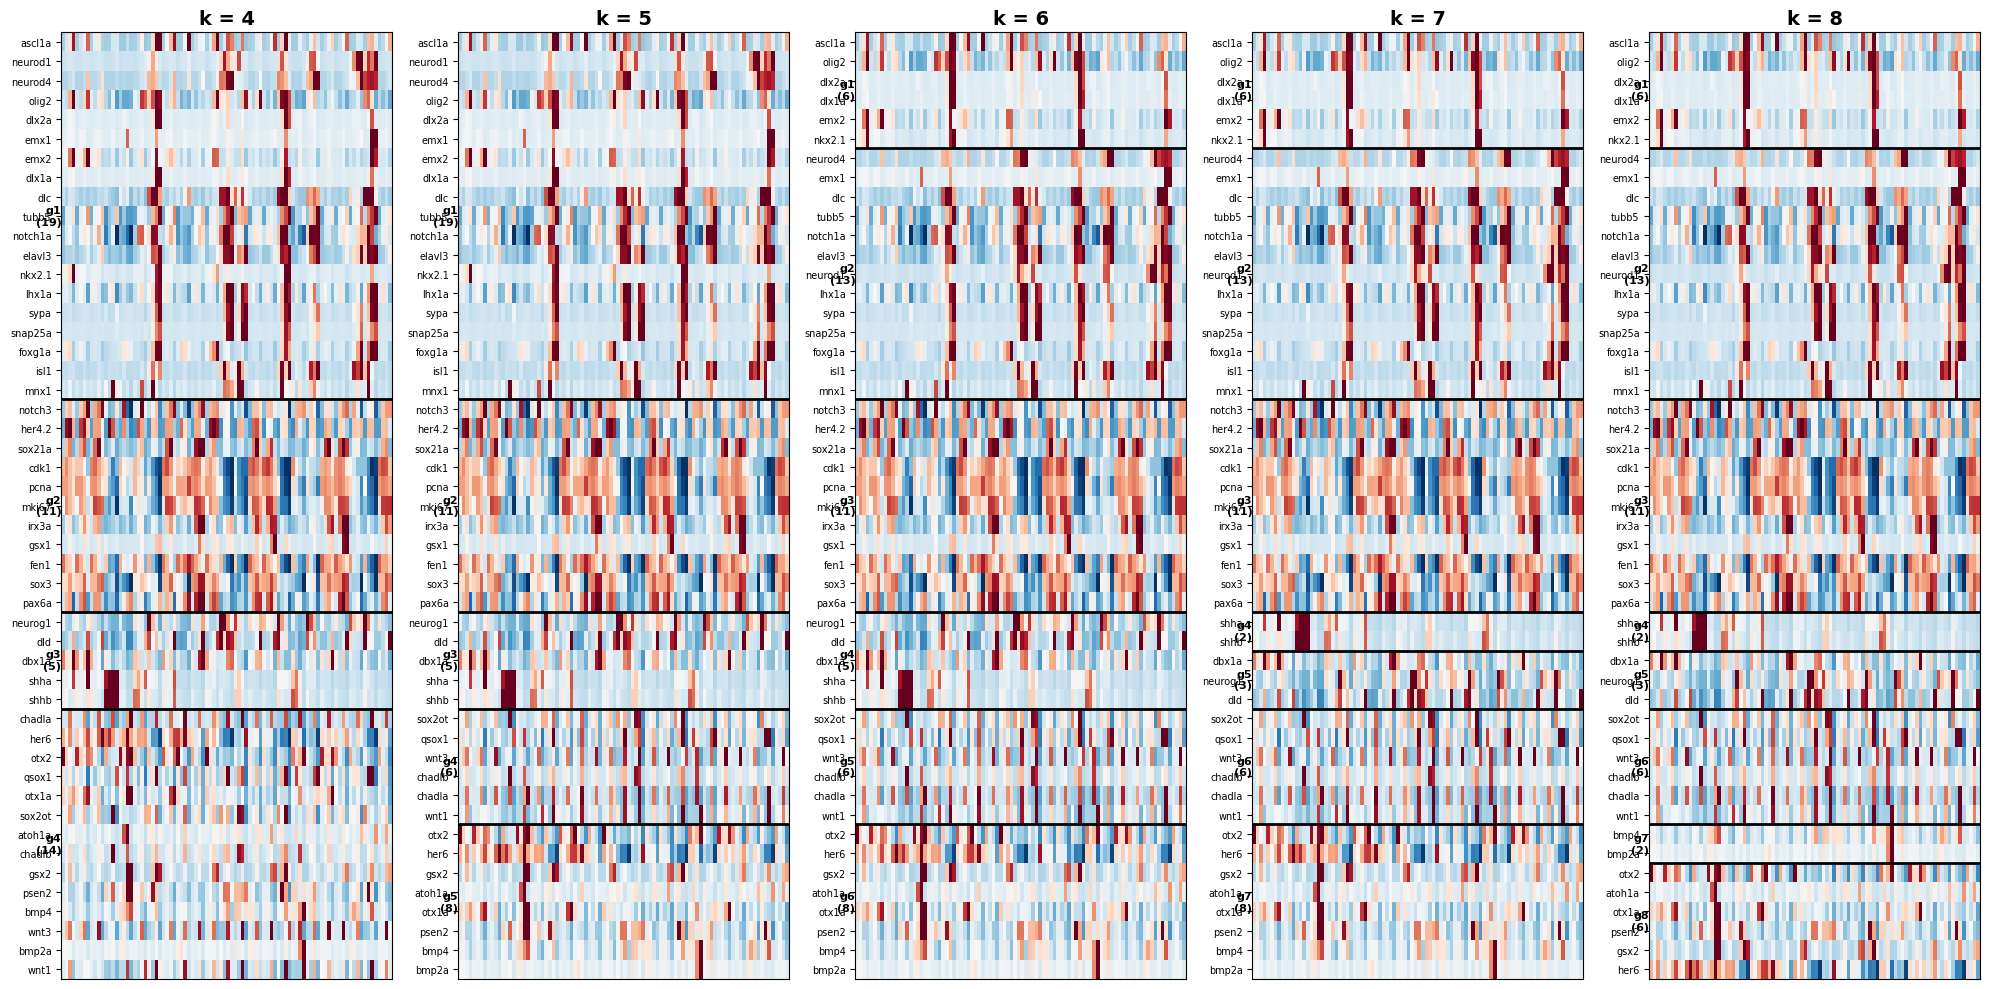


k = 4 CLUSTER CONTENTS

g1 (19 genes): ascl1a, neurod1, neurod4, olig2, dlx1a, dlx2a, emx1, emx2, nkx2.1, notch1a, dlc, elavl3, tubb5, snap25a, sypa, foxg1a, lhx1a, isl1, mnx1

g2 (11 genes): sox3, sox21a, pax6a, fen1, gsx1, notch3, her4.2, irx3a, mki67, pcna, cdk1

g3 (5 genes): neurog1, dld, shha, shhb, dbx1a

g4 (14 genes): atoh1a, sox2ot, qsox1, otx1a, otx2, psen2, gsx2, chadla, chadlb, her6, wnt1, wnt3, bmp2a, bmp4

k = 5 CLUSTER CONTENTS

g1 (19 genes): ascl1a, neurod1, neurod4, olig2, dlx1a, dlx2a, emx1, emx2, nkx2.1, notch1a, dlc, elavl3, tubb5, snap25a, sypa, foxg1a, lhx1a, isl1, mnx1

g2 (11 genes): sox3, sox21a, pax6a, fen1, gsx1, notch3, her4.2, irx3a, mki67, pcna, cdk1

g3 (5 genes): neurog1, dld, shha, shhb, dbx1a

g4 (6 genes): sox2ot, qsox1, chadla, chadlb, wnt1, wnt3

g5 (8 genes): atoh1a, otx1a, otx2, psen2, gsx2, her6, bmp2a, bmp4

k = 6 CLUSTER CONTENTS

g1 (6 genes): ascl1a, olig2, dlx1a, dlx2a, emx2, nkx2.1

g2 (13 genes): neurod1, neurod4, emx1, notch1a, dlc, el

In [153]:
#Comparing different k clusters

def compare_cluster_solutions(expr_matrix, linkage_matrix, k_values=[4, 5, 6, 7, 8]):
    """
    Compare cluster solutions at different k values to assess biological interpretability.
    """
    from scipy.cluster.hierarchy import fcluster
    
    fig, axes = plt.subplots(1, len(k_values), figsize=(4*len(k_values), 10))
    
    for idx, k in enumerate(k_values):
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        # Sort by cluster
        order = np.argsort(labels)
        sorted_data = expr_matrix.values[order]
        sorted_labels = labels[order]
        sorted_genes = expr_matrix.index[order]
        
        ax = axes[idx]
        im = ax.imshow(sorted_data, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title(f'k = {k}', fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks(range(len(sorted_genes)))
        ax.set_yticklabels(sorted_genes, fontsize=7)
        
        # Add cluster boundaries
        boundaries = np.where(np.diff(sorted_labels))[0] + 0.5
        for b in boundaries:
            ax.axhline(y=b, color='black', linewidth=2)
        
        # Label clusters
        cluster_positions = []
        for c in range(1, k+1):
            positions = np.where(sorted_labels == c)[0]
            if len(positions) > 0:
                center = np.mean(positions)
                cluster_positions.append((c, center, len(positions)))
        
        for c, pos, size in cluster_positions:
            ax.text(-0.5, pos, f'g{c}\n({size})', fontsize=8, 
                   ha='right', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('cluster_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print cluster contents for each k
    for k in k_values:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        print(f"\n{'='*50}")
        print(f"k = {k} CLUSTER CONTENTS")
        print('='*50)
        
        for c in range(1, k+1):
            genes = expr_matrix.index[labels == c].tolist()
            print(f"\ng{c} ({len(genes)} genes): {', '.join(genes)}")


# Run the comparison
compare_cluster_solutions(expr_matrix, linkage_matrix, k_values=[4, 5, 6, 7, 8])

Saved to gene_modules_heatmap_k6_by_timepoint.png


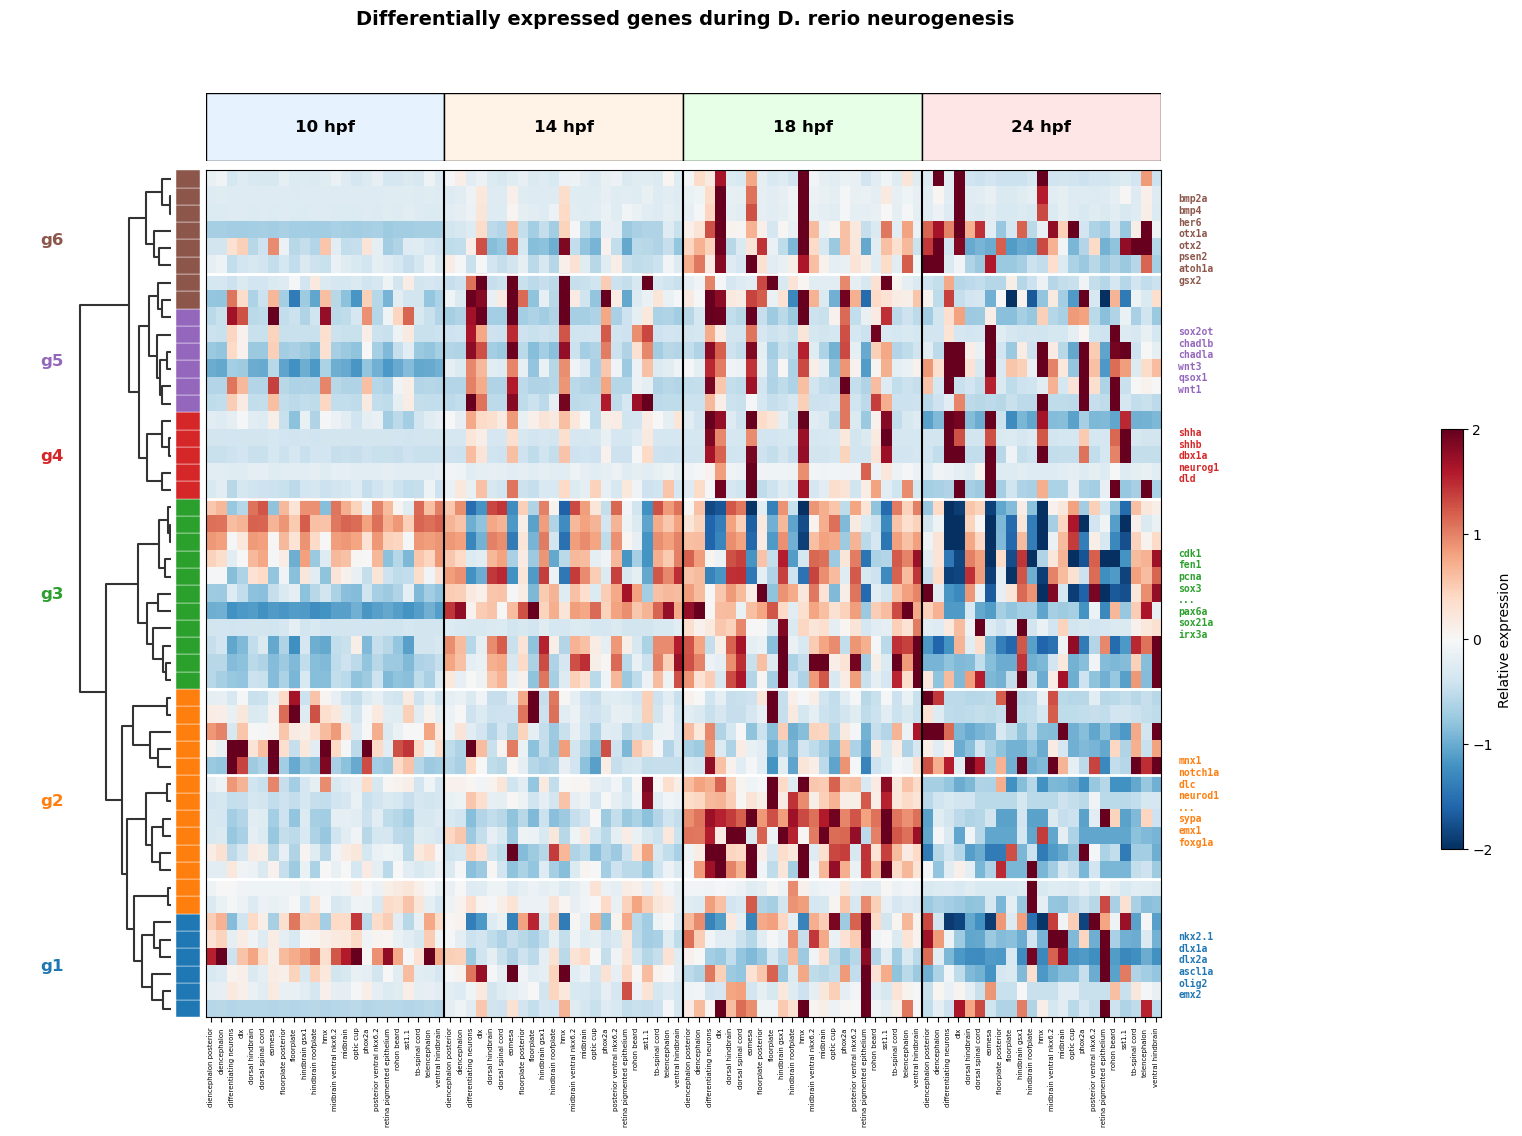


CLUSTER SUMMARY WITH TEMPORAL PATTERNS

g1 - Ventral/forebrain patterning
   Temporal: ↑ increasing
   Mean z-score: 10hpf: -0.33 → 14hpf: -0.24 → 18hpf: 0.25 → 24hpf: 0.32
   Genes (6): ascl1a, olig2, dlx1a, dlx2a, emx2, nkx2.1

g2 - Neuronal differentiation
   Temporal: ↑ increasing
   Mean z-score: 10hpf: -0.34 → 14hpf: 0.03 → 18hpf: 0.15 → 24hpf: 0.16
   Genes (13): neurod1, neurod4, emx1, notch1a, dlc, elavl3, tubb5, snap25a, sypa, foxg1a, lhx1a, isl1, mnx1

g3 - Progenitor/proliferation
   Temporal: ⌃ peaks at 18hpf
   Mean z-score: 10hpf: -0.20 → 14hpf: 0.21 → 18hpf: 0.29 → 24hpf: -0.31
   Genes (11): sox3, sox21a, pax6a, fen1, gsx1, notch3, her4.2, irx3a, mki67, pcna, cdk1

g4 - Shh signaling + neurogenesis
   Temporal: → stable
   Mean z-score: 10hpf: 0.23 → 14hpf: -0.15 → 18hpf: -0.18 → 24hpf: 0.10
   Genes (5): neurog1, dld, shha, shhb, dbx1a

g5 - Wnt signaling
   Temporal: ↓ decreasing
   Mean z-score: 10hpf: -0.26 → 14hpf: -0.22 → 18hpf: 1.05 → 24hpf: -0.57
   Genes (6):

In [196]:
"""
    Creating clustered heatmap with improved label positioning.
"""

def final_clustered_heatmap_by_timepoint(expr_matrix, linkage_matrix, n_clusters=6, save_path=None):
    
    from scipy.cluster.hierarchy import dendrogram, fcluster
    
    # Get cluster assignments
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Get dendrogram order for genes
    dendro = dendrogram(linkage_matrix, no_plot=True)
    dendro_order = dendro['leaves']
    
    # Reorder genes by dendrogram
    df_ordered = expr_matrix.iloc[dendro_order]
    labels_ordered = labels[dendro_order]
    
    # Reorganize columns by timepoint
    timepoints = [10, 14, 18, 24]
    
    # Group columns by timepoint
    cols_by_timepoint = {t: [] for t in timepoints}
    for col in df_ordered.columns:
        for t in timepoints:
            if f'_{t}hpf' in col:
                cols_by_timepoint[t].append(col)
                break
    
    # Sort trajectories within each timepoint alphabetically for consistency
    for t in timepoints:
        cols_by_timepoint[t] = sorted(cols_by_timepoint[t])
    
    # Create new column order
    new_col_order = []
    timepoint_boundaries = []
    for t in timepoints:
        if cols_by_timepoint[t]:
            timepoint_boundaries.append(len(new_col_order))
            new_col_order.extend(cols_by_timepoint[t])
    timepoint_boundaries.append(len(new_col_order))
    
    # Reorder columns
    df_reordered = df_ordered[new_col_order]
    
    # Create figure
    fig = plt.figure(figsize=(18, 12))
    
    # Grid: cluster_labels | dendrogram | cluster bar | heatmap | gene labels
    # Added extra column for cluster labels
    gs = fig.add_gridspec(2, 5, width_ratios=[0.25, 0.4, 0.1, 4, 1.0], 
                          height_ratios=[0.08, 1], wspace=0.02, hspace=0.02)
    
    # Cluster colors
    cluster_colors = {
        1: '#1f77b4',  # blue
        2: '#ff7f0e',  # orange
        3: '#2ca02c',  # green
        4: '#d62728',  # red
        5: '#9467bd',  # purple
        6: '#8c564b',  # brown
        7: '#e377c2',  # pink
        8: '#7f7f7f',  # gray
    }
    
    # Top row: timepoint labels (now in column 3 instead of 2)
    ax_time = fig.add_subplot(gs[0, 3])
    ax_time.set_xlim(0, len(new_col_order))
    ax_time.set_ylim(0, 1)
    
    # Add timepoint headers with background colors
    time_colors = ['#e6f3ff', '#fff2e6', '#e6ffe6', '#ffe6e6']
    for i, t in enumerate(timepoints):
        start = timepoint_boundaries[i]
        end = timepoint_boundaries[i + 1]
        width = end - start
        
        # Background color block
        ax_time.add_patch(plt.Rectangle((start, 0), width, 1, 
                                        facecolor=time_colors[i], 
                                        edgecolor='black', linewidth=1))
        # Label
        ax_time.text((start + end) / 2, 0.5, f'{t} hpf', 
                    fontsize=12, fontweight='bold', ha='center', va='center')
    
    ax_time.set_axis_off()
    
    # Hide unused top-row axes
    for col in [0, 1, 2, 4]:
        ax_empty = fig.add_subplot(gs[0, col])
        ax_empty.set_axis_off()
    
    # 1. Cluster labels column (NEW - dedicated axis for labels)
    ax_labels = fig.add_subplot(gs[1, 0])
    ax_labels.set_xlim(0, 1)
    ax_labels.set_ylim(0, len(labels_ordered))
    ax_labels.set_axis_off()
    
    # Add cluster labels with better positioning
    current_cluster = labels_ordered[0]
    cluster_start = 0
    
    for i in range(len(labels_ordered)):
        if i == len(labels_ordered) - 1 or labels_ordered[i+1] != labels_ordered[i]:
            center = (cluster_start + i + 1) / 2
            ax_labels.text(0.9, center, f'g{labels_ordered[i]}', 
                          fontsize=12, fontweight='bold', va='center', ha='right',
                          color=cluster_colors[labels_ordered[i]])
            if i < len(labels_ordered) - 1:
                cluster_start = i + 1
    
    # 2. Dendrogram
    ax_dendro = fig.add_subplot(gs[1, 1])
    dendro_plot = dendrogram(linkage_matrix, orientation='left', no_labels=True,
                             color_threshold=0, above_threshold_color='#333333', 
                             ax=ax_dendro)
    ax_dendro.set_axis_off()
    ax_dendro.invert_yaxis()
    
    # 3. Cluster color bar
    ax_clusters = fig.add_subplot(gs[1, 2])
    
    for i, cluster_id in enumerate(labels_ordered):
        ax_clusters.add_patch(plt.Rectangle((0, i), 1, 1, 
                                            facecolor=cluster_colors[cluster_id], 
                                            edgecolor='white', linewidth=0.3))
    
    ax_clusters.set_xlim(0, 1)
    ax_clusters.set_ylim(0, len(labels_ordered))
    ax_clusters.set_axis_off()
    
    # 4. Main heatmap
    ax_heatmap = fig.add_subplot(gs[1, 3])
    
    im = ax_heatmap.imshow(df_reordered.values, aspect='auto', 
                           cmap='RdBu_r', vmin=-2, vmax=2)
    
    # Simplify column labels (just trajectory name, no timepoint)
    col_labels = []
    for col in new_col_order:
        parts = col.rsplit('_', 1)
        if len(parts) == 2:
            traj = parts[0].replace('neural - ', '').replace('tailbud - ', 'tb-')
            col_labels.append(traj)
        else:
            col_labels.append(col)
    
    ax_heatmap.set_xticks(range(len(col_labels)))
    ax_heatmap.set_xticklabels(col_labels, rotation=90, ha='center', fontsize=5)
    ax_heatmap.set_yticks([])
    
    # Add horizontal lines between gene clusters
    for i in range(len(labels_ordered) - 1):
        if labels_ordered[i] != labels_ordered[i + 1]:
            ax_heatmap.axhline(y=i + 0.5, color='white', linewidth=2)
    
    # Add vertical lines between timepoints
    for boundary in timepoint_boundaries[1:-1]:
        ax_heatmap.axvline(x=boundary - 0.5, color='black', linewidth=1.5)
    
    # 5. Gene labels on right
    ax_genes = fig.add_subplot(gs[1, 4])
    ax_genes.set_xlim(0, 1)
    ax_genes.set_ylim(0, len(df_reordered))
    ax_genes.set_axis_off()
    
    current_cluster = labels_ordered[0]
    cluster_start = 0
    
    for i in range(len(labels_ordered)):
        if i == len(labels_ordered) - 1 or labels_ordered[i+1] != labels_ordered[i]:
            cluster_genes = df_reordered.index[cluster_start:i+1].tolist()
            center = (cluster_start + i + 1) / 2
            
            # Show all genes or truncate if too many
            if len(cluster_genes) <= 8:
                gene_text = '\n'.join(cluster_genes)
            else:
                gene_text = '\n'.join(cluster_genes[:4] + ['...'] + cluster_genes[-3:])
            
            ax_genes.text(0.05, center, gene_text, fontsize=7, va='center', 
                         fontweight='bold', color=cluster_colors[labels_ordered[i]],
                         family='monospace')
            
            if i < len(labels_ordered) - 1:
                cluster_start = i + 1
    
    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.012, 0.35])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label('Relative expression', fontsize=10)
    cbar.set_ticks([-2, -1, 0, 1, 2])
    
    plt.suptitle('Differentially expressed genes during D. rerio neurogenesis', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")
    
    plt.show()
    
    # Print summary with temporal dynamics
    print("\n" + "="*70)
    print("CLUSTER SUMMARY WITH TEMPORAL PATTERNS")
    print("="*70)
    
    cluster_annotations = {
        1: "Ventral/forebrain patterning",
        2: "Neuronal differentiation", 
        3: "Progenitor/proliferation",
        4: "Shh signaling + neurogenesis",
        5: "Wnt signaling",
        6: "BMP + dorsal/sensory"
    }
    
    for c in range(1, n_clusters + 1):
        cluster_mask = labels == c
        cluster_genes = expr_matrix.index[cluster_mask].tolist()
        cluster_data = expr_matrix.loc[cluster_mask]
        
        # Calculate mean expression at each timepoint
        mean_by_time = {}
        for t in timepoints:
            time_cols = [col for col in cluster_data.columns if f'_{t}hpf' in col]
            if time_cols:
                mean_by_time[t] = cluster_data[time_cols].values.mean()
        
        # Determine temporal pattern
        values = list(mean_by_time.values())
        peak_time = timepoints[np.argmax(values)]
        
        if values[-1] > values[0] + 0.3:
            pattern = "↑ increasing"
        elif values[-1] < values[0] - 0.3:
            pattern = "↓ decreasing"
        elif max(values) > values[0] + 0.3 and max(values) > values[-1] + 0.3:
            pattern = f"⌃ peaks at {peak_time}hpf"
        else:
            pattern = "→ stable"
        
        annotation = cluster_annotations.get(c, "")
        print(f"\ng{c} - {annotation}")
        print(f"   Temporal: {pattern}")
        print(f"   Mean z-score: " + " → ".join([f"{t}hpf: {mean_by_time[t]:.2f}" for t in timepoints]))
        print(f"   Genes ({len(cluster_genes)}): {', '.join(cluster_genes)}")

        
# Timepoint-organized heatmap
final_clustered_heatmap_by_timepoint(
    expr_matrix, 
    linkage_matrix, 
    n_clusters=6,
    save_path='gene_modules_heatmap_k6_by_timepoint.png'
)

#### Computing Transition Table

In [163]:
# Defining starting and ending populations

cells_10 = adata_neural[adata_neural.obs['TimeID'] == 10.0].obs_names
cells_24 = adata_neural[adata_neural.obs['TimeID'] == 24.0].obs_names

print(f"Cells at 10 hpf: {len(cells_10)}")
print(f"Cells at 24 hpf: {len(cells_24)}")

# Get cluster compositions at each timepoint
clusters_10 = adata_neural[adata_neural.obs['TimeID'] == 10.0].obs['ClusterName'].value_counts()
clusters_24 = adata_neural[adata_neural.obs['TimeID'] == 24.0].obs['ClusterName'].value_counts()

print("\nClusters at 10 hpf:")
print(clusters_10)
print("\nClusters at 24 hpf:")
print(clusters_24)

Cells at 10 hpf: 2324
Cells at 24 hpf: 23070

Clusters at 10 hpf:
ClusterName
10hpf-tailbud - spinal cord      1009
10hpf-neural - midbrain           367
10hpf-neural - anterior           318
10hpf-neural - hindbrain          305
10hpf-neural - diencephalon       134
10hpf-neural - telencephalon      126
10hpf-differentiating neurons      65
Name: count, dtype: int64

Clusters at 24 hpf:
ClusterName
24hpf-neural - midbrain                        3920
24hpf-neural - ventral hindbrain               3111
24hpf-optic cup                                3091
24hpf-differentiating neurons                  2921
24hpf-neural - dorsal hindbrain                2520
24hpf-tailbud - spinal cord                    1243
24hpf-neural - telencephalon                   1241
24hpf-neural - hindbrain gsx1                   848
24hpf-neural - diencephalon                     764
24hpf-neural - midbrain ventral nkx6.2          667
24hpf-neural - posterior ventral nkx6.2         469
24hpf-differentiating neu

In [197]:
# Function for computing transition table

def compute_transition_table(adata, tmap_model, source_time, target_time, 
                             cluster_col='ClusterName', min_cells=10):
    
    # Get cells at source and target times
    source_mask = adata.obs['TimeID'] == source_time
    target_mask = adata.obs['TimeID'] == target_time
    
    # Get unique clusters at each timepoint (filtered by min_cells)
    source_clusters = adata.obs.loc[source_mask, cluster_col].value_counts()
    source_clusters = source_clusters[source_clusters >= min_cells].index.tolist()
    
    target_clusters = adata.obs.loc[target_mask, cluster_col].value_counts()
    target_clusters = target_clusters[target_clusters >= min_cells].index.tolist()
    
    print(f"Source clusters at {source_time} hpf: {len(source_clusters)}")
    print(f"Target clusters at {target_time} hpf: {len(target_clusters)}")
    
    # Create cell sets for source populations
    source_cell_sets = {}
    for cluster in source_clusters:
        mask = (adata.obs['TimeID'] == source_time) & (adata.obs[cluster_col] == cluster)
        source_cell_sets[cluster] = set(adata.obs_names[mask])
    
    # Create cell sets for target populations
    target_cell_sets = {}
    for cluster in target_clusters:
        mask = (adata.obs['TimeID'] == target_time) & (adata.obs[cluster_col] == cluster)
        target_cell_sets[cluster] = set(adata.obs_names[mask])
    
    # Write target cell sets to GMT file
    with open('target_cell_sets.gmt', 'w') as f:
        for name, cells in target_cell_sets.items():
            f.write(f"{name}\t{name}\t" + "\t".join(cells) + "\n")
    
    # Load cell sets and compute trajectories
    target_sets = wot.io.read_sets('target_cell_sets.gmt', as_dict=True)
    target_populations = tmap_model.population_from_cell_sets(target_sets, at_time=target_time)
    trajectory_ds = tmap_model.trajectories(target_populations)
    
    # trajectory_ds is an AnnData object
    # - obs contains 'day' column indicating timepoint
    # - var_names are the target cluster names
    # - X contains the trajectory probabilities
    
    print(f"\nTrajectory dataset shape: {trajectory_ds.shape}")
    print(f"Timepoints in trajectory: {trajectory_ds.obs['day'].unique()}")
    print(f"Target populations: {list(trajectory_ds.var_names)}")
    
    # Get cells at source time from trajectory dataset
    source_time_mask = trajectory_ds.obs['day'] == source_time
    source_cells_in_traj = trajectory_ds.obs_names[source_time_mask]
    
    print(f"Cells at source time in trajectory: {len(source_cells_in_traj)}")
    
    # Extract probability matrix for source time cells
    source_probs_X = trajectory_ds[source_time_mask, :].X
    source_probs_cells = trajectory_ds.obs_names[source_time_mask]
    source_probs_targets = trajectory_ds.var_names
    
    # Create a DataFrame for easier indexing
    source_probs_df = pd.DataFrame(
        source_probs_X,
        index=source_probs_cells,
        columns=source_probs_targets
    )
    
    # Compute transition matrix
    transition_matrix = np.zeros((len(source_clusters), len(target_clusters)))
    
    for i, source_cluster in enumerate(source_clusters):
        # Get cells in this source cluster
        source_cells_in_cluster = list(source_cell_sets[source_cluster])
        
        # Find cells that are both in this cluster and in trajectory data
        cells_in_probs = [c for c in source_cells_in_cluster if c in source_probs_df.index]
        
        if len(cells_in_probs) > 0:
            # For each target cluster, compute mean probability
            for j, target_cluster in enumerate(target_clusters):
                if target_cluster in source_probs_df.columns:
                    probs = source_probs_df.loc[cells_in_probs, target_cluster].values
                    transition_matrix[i, j] = np.mean(probs)
        
        print(f"  {source_cluster}: {len(cells_in_probs)} cells matched")
    
    # Normalize rows to sum to 1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    transition_matrix_norm = transition_matrix / row_sums
    
    # Create DataFrame
    transition_df = pd.DataFrame(
        transition_matrix_norm,
        index=source_clusters,
        columns=target_clusters
    )
    
    return transition_df, transition_matrix


# Compute the transition table
transition_df, raw_matrix = compute_transition_table(
    adata_neural, 
    tmap_model, 
    source_time=10.0, 
    target_time=24.0,
    cluster_col='ClusterName',
    min_cells=10
)

print("\nTransition probability matrix (10 hpf → 24 hpf):")
print(transition_df.round(3))

Source clusters at 10.0 hpf: 7
Target clusters at 24.0 hpf: 23

Trajectory dataset shape: (31110, 23)
Timepoints in trajectory: [10. 14. 18. 24.]
Target populations: ['24hpf-neural - midbrain', '24hpf-neural - ventral hindbrain', '24hpf-optic cup', '24hpf-differentiating neurons', '24hpf-neural - dorsal hindbrain', '24hpf-tailbud - spinal cord', '24hpf-neural - telencephalon', '24hpf-neural - hindbrain gsx1', '24hpf-neural - diencephalon', '24hpf-neural - midbrain ventral nkx6.2', '24hpf-neural - posterior ventral nkx6.2', '24hpf-differentiating neurons - eomesa', '24hpf-differentiating neurons - dlx', '24hpf-neural - dorsal spinal cord', '24hpf-differentiating neurons - rohon beard', '24hpf-differentiating neurons - phox2a', '24hpf-neural - diencephalon posterior', '24hpf-retina pigmented epithelium', '24hpf-neural - hindbrain roofplate', '24hpf-differentiating neurons - hmx', '24hpf-differentiating neurons - sst1.1', '24hpf-neural - floorplate posterior', '24hpf-neural - floorplate']

Saved to transition_sankey_10_24hpf.png


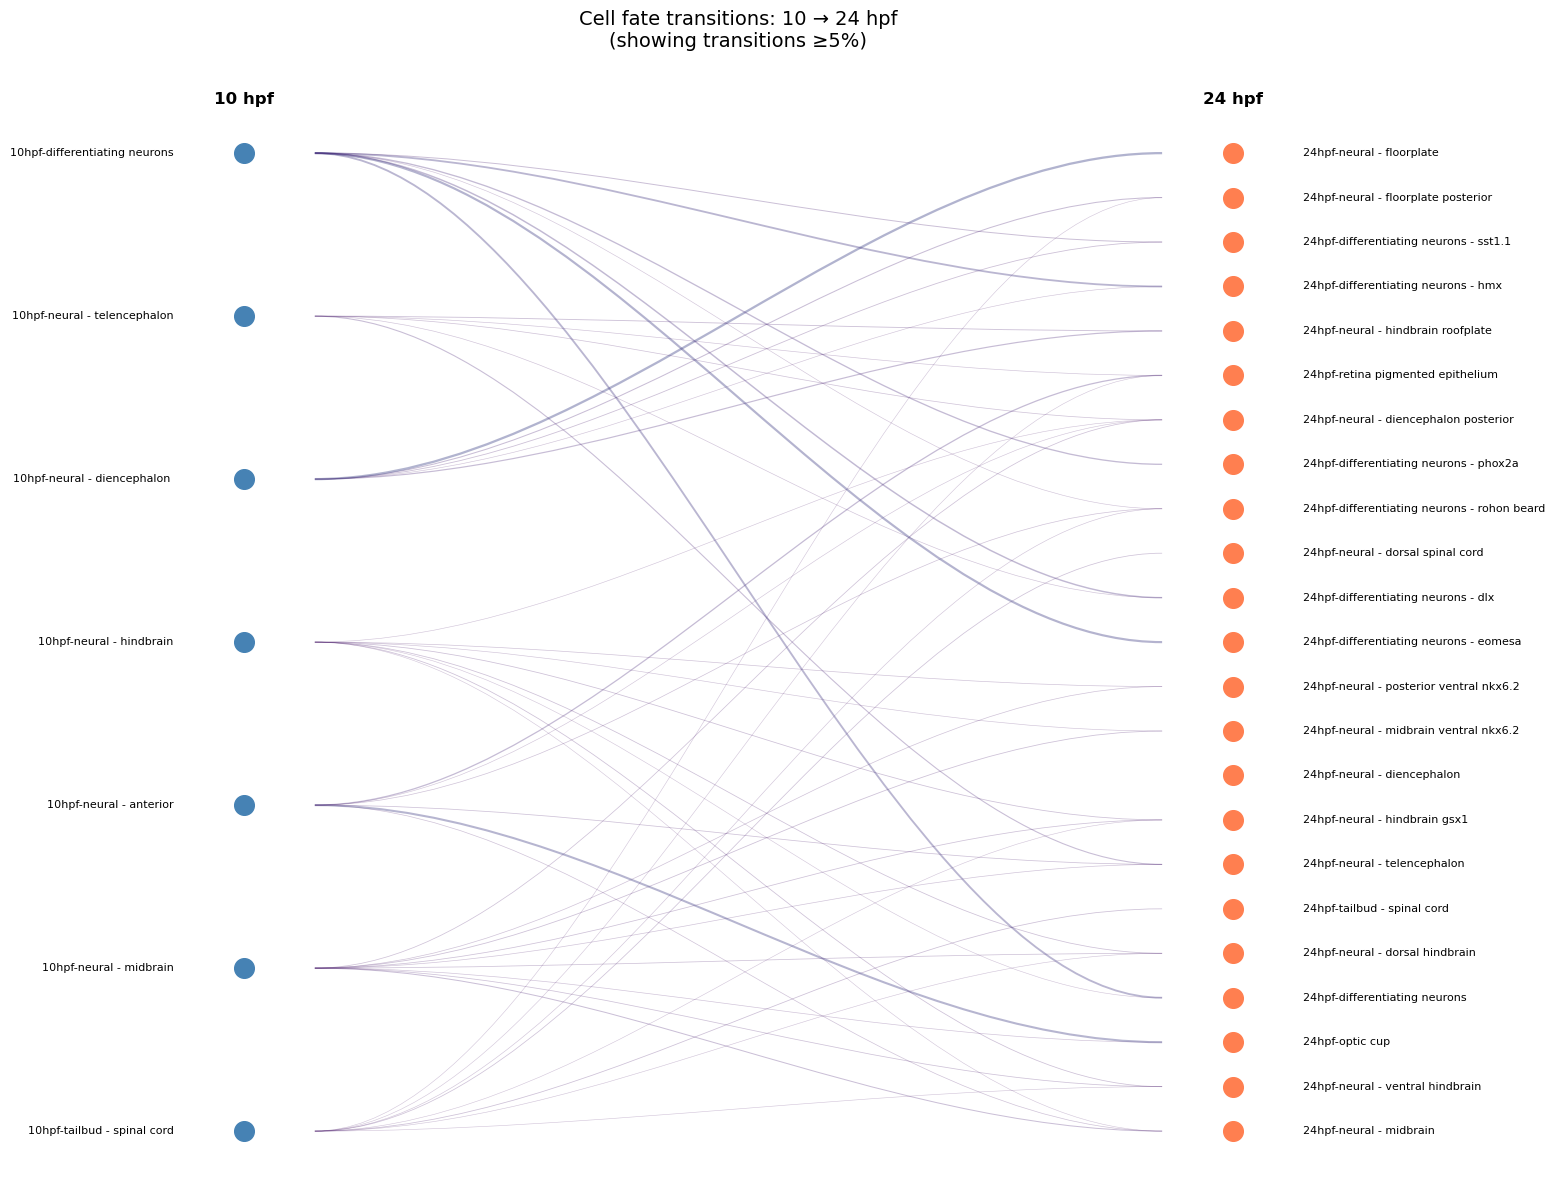

In [171]:
def plot_transition_sankey(transition_df, source_time, target_time, 
                           threshold=0.05, save_path=None):
    """
    Plot transition probabilities as a Sankey-style flow diagram.
    """
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    source_clusters = transition_df.index.tolist()
    target_clusters = transition_df.columns.tolist()
    
    # Positions
    n_source = len(source_clusters)
    n_target = len(target_clusters)
    
    source_y = np.linspace(0, 1, n_source)
    target_y = np.linspace(0, 1, n_target)
    
    # Draw connections
    for i, source in enumerate(source_clusters):
        for j, target in enumerate(target_clusters):
            prob = transition_df.loc[source, target]
            
            if prob >= threshold:
                # Line width proportional to probability
                linewidth = prob * 8
                alpha = min(0.8, prob + 0.2)
                
                # Draw curved connection
                from matplotlib.patches import FancyArrowPatch
                from matplotlib.path import Path
                import matplotlib.patches as mpatches
                
                # Bezier curve control points
                x_src, y_src = 0.2, source_y[i]
                x_tgt, y_tgt = 0.8, target_y[j]
                
                verts = [
                    (x_src, y_src),
                    (0.4, y_src),
                    (0.6, y_tgt),
                    (x_tgt, y_tgt)
                ]
                codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
                path = Path(verts, codes)
                
                patch = mpatches.PathPatch(path, facecolor='none', 
                                          edgecolor=plt.cm.viridis(prob),
                                          linewidth=linewidth, alpha=alpha)
                ax.add_patch(patch)
    
    # Draw source nodes
    for i, source in enumerate(source_clusters):
        ax.scatter(0.15, source_y[i], s=200, c='steelblue', zorder=10)
        ax.text(0.1, source_y[i], source, ha='right', va='center', fontsize=8)
    
    # Draw target nodes
    for j, target in enumerate(target_clusters):
        ax.scatter(0.85, target_y[j], s=200, c='coral', zorder=10)
        ax.text(0.9, target_y[j], target, ha='left', va='center', fontsize=8)
    
    # Labels
    ax.text(0.15, 1.05, f'{source_time} hpf', ha='center', fontsize=12, fontweight='bold')
    ax.text(0.85, 1.05, f'{target_time} hpf', ha='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1.1)
    ax.set_axis_off()
    ax.set_title(f'Cell fate transitions: {source_time} → {target_time} hpf\n(showing transitions ≥{threshold:.0%})', 
                fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()


# Plot Sankey diagram
plot_transition_sankey(
    transition_df,
    source_time=10,
    target_time=24,
    threshold=0.05,
    save_path='transition_sankey_10_24hpf.png'
)

Saved to heat_map_transition_table_10_24hpf.png


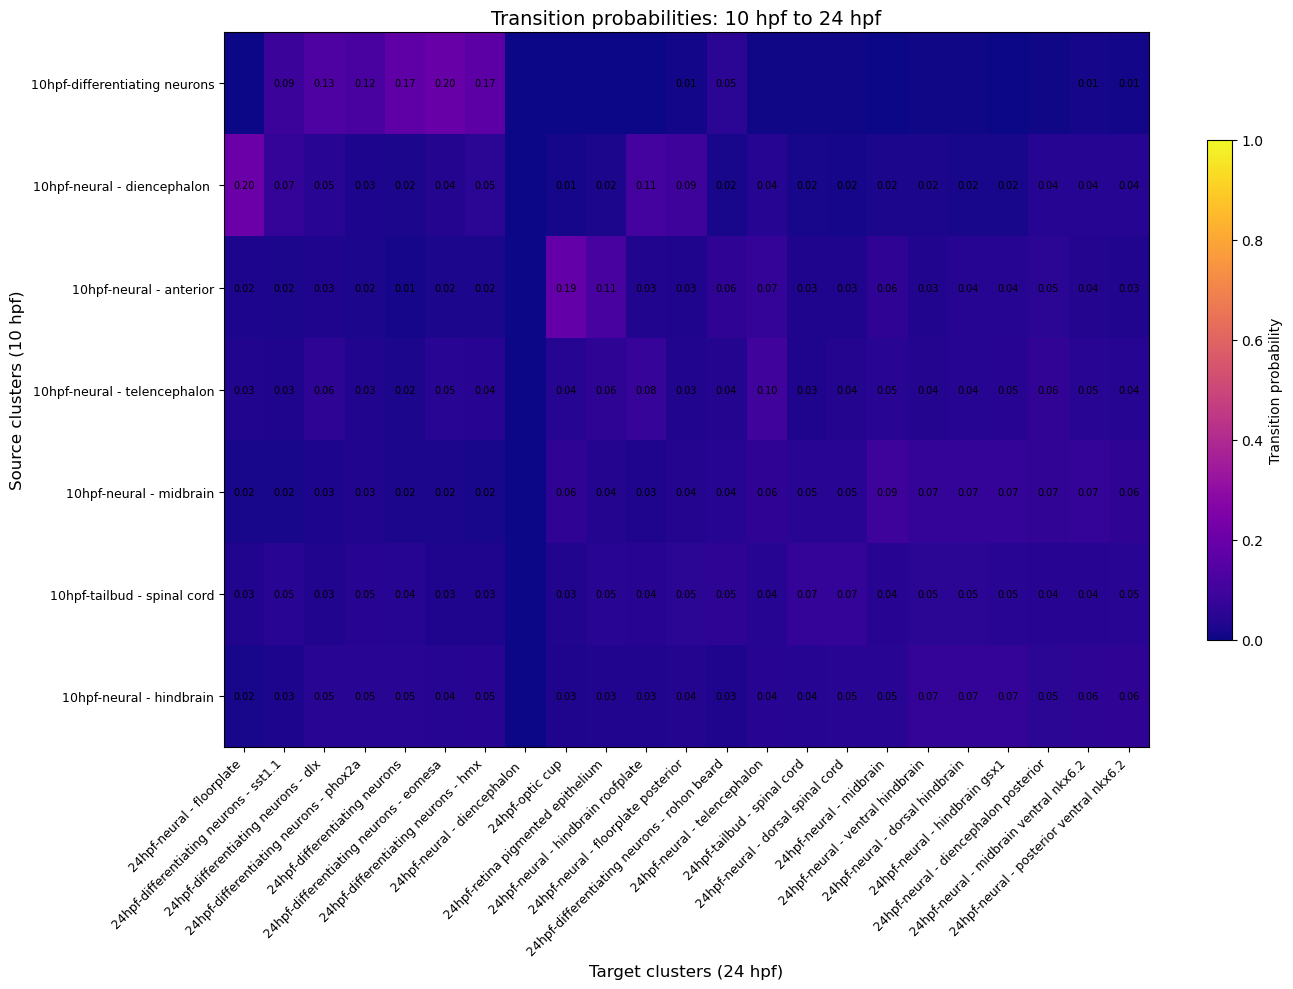

In [199]:
# Function for plotting cell state transition heatmap

def plot_transition_heatmap(transition_df, source_time, target_time, save_path=None):

    
    # Sort by hierarchical clustering for better visualization
    from scipy.cluster.hierarchy import linkage, dendrogram
    from scipy.spatial.distance import pdist
    
    # Cluster rows and columns
    if len(transition_df) > 2:
        row_linkage = linkage(pdist(transition_df.values + 1e-10), method='average')
        row_order = dendrogram(row_linkage, no_plot=True)['leaves']
    else:
        row_order = list(range(len(transition_df)))
    
    if len(transition_df.columns) > 2:
        col_linkage = linkage(pdist(transition_df.values.T + 1e-10), method='average')
        col_order = dendrogram(col_linkage, no_plot=True)['leaves']
    else:
        col_order = list(range(len(transition_df.columns)))
    
    # Reorder
    df_ordered = transition_df.iloc[row_order, col_order]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Heatmap
    im = ax.imshow(df_ordered.values, cmap='plasma', aspect='auto', vmin=0, vmax=1)
    
    # Labels
    ax.set_xticks(range(len(df_ordered.columns)))
    ax.set_xticklabels(df_ordered.columns, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(len(df_ordered.index)))
    ax.set_yticklabels(df_ordered.index, fontsize=9)
    
    ax.set_xlabel(f'Target clusters ({target_time} hpf)', fontsize=12)
    ax.set_ylabel(f'Source clusters ({source_time} hpf)', fontsize=12)
    ax.set_title(f'Transition probabilities: {source_time} hpf to {target_time} hpf', fontsize=14)
    
    # Add text annotations
    for i in range(len(df_ordered.index)):
        for j in range(len(df_ordered.columns)):
            val = df_ordered.iloc[i, j]
            if val > 0.01:  # Only show non-negligible values
                color = 'white' if val > 0.5 else 'black'
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                       color=color, fontsize=7)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label('Transition probability', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()
    
    return df_ordered


# Plotring the transition heatmap
transition_ordered = plot_transition_heatmap(
    transition_df, 
    source_time=10, 
    target_time=24,
    save_path='heat_map_transition_table_10_24hpf.png'
)